# Holiday Shopper Segmentation: Clustering, Frequent Itemset Mining, & Recommendations


**Data Source:** [UC Irvine Machine Learning Repository: Online Retail Dataset](https://archive.ics.uci.edu/dataset/352/online+retail)  

---
## Approach and Methodology
1. Problem Definition and Data Gathering
2. Exploratory Data Analysis (EDA)
3. Model Building and Analysis
4. Discussion and Conclusion






## 1. Problem Definition and Data Gathering

## Project Topic

To group holiday shoppers into meaningful segments using unsupervised learning techniques. Businesses that understand customer behavior, especially during peak shopping seasons, can adjust their marketing strategies more effectively. After exploring this e-commerce dataset and noticing that the majority of purchases occur in November and December, I decided to focus on holiday time period transactions. Because there are no explicit labels for holiday shopper type, clustering is a great approach to discover these segments.


## Project Goal

The primary goal is to apply **K-Means** and **Hierarchical Clustering** to segment holiday shoppers into distinct groups:

 - Non-Holiday Shoppers (low holiday purchases and spending)
 - Moderate Holiday Shoppers (moderate holiday purchases and spending)
 - Frequent Holiday Shoppers (high holiday purchases and spending)

By identifying these clusters, this business can personalize promotions, recommend relevant products, and develop targeted marketing campaigns to boost sales. In addition to clustering, **Frequent Itemset Mining** (via FPGrowth) will discover which items often occur together, supporting a simple **rule-based recommendation system** that suggests products frequently purchased together.

Finally, I will also show a more advanced **recommender using implicit feedback** (purchased vs. not purchased) with the implicit library. This dual approach of simple rule-based and implicit collaborative filtering recommenders highlights two different methods for making product suggestions to holiday shoppers.


## Data Section

### Data Source

The data used in this project is sourced from the [UC Irvine Machine Learning Repository: Online Retail Dataset](https://archive.ics.uci.edu/dataset/352/online+retail). It is a publicly available dataset provided by a UK-based and registered online retail company. The data can be downloaded from the link above.

### Data Description

The dataset contains 8 features and 541,909 rows of customer data, with a total size of  **23.7 MB**. Each row represents a transaction, and the columns represent attributes about the transaction. Transactions ocurred from December 1, 2010 to December 31, 2011.


- **Number of rows (samples):** 541,909  
- **Number of columns (features):** 8  
- **Data Size:** ~23.7 MB

**Key Features:**
- **Categorical Features:** `InvoiceNo`, `StockCode`, `Description`,  `InvoiceDate`, `CustomerID`, `Country`
- **Numerical Features:** `Quantity`, `UnitPrice`

**Context:**  
The retailer specializes in unique gifts and sold through catalogs and phone orders before transitioning online two years before this datasets creation. This dataset has a large number of transactions, primarily in the UK and Europe over a 13-month period, making it a good source for understanding customer behavior.

**Why This Dataset?**

With both categorical and numerical features, the Online Retail data provides a realistic setting for unsupervised analysis of shopper patterns. Also, it provides a real-world application for holiday shopper segmentation and product recommendation.

**Data Attributes:**
- Total rows: **541,909**  
- Total columns: **8**  
- Examples of column names: `InvoiceNo`, `StockCode`, `Description`, `InvoiceDate`, `CustomerID`, `Country`, `Quantity`, `UnitPrice`   

In the following sections, I will conduct Exploratory Data Analysis (EDA) to clean and understand the data, then build and analyze the clustering models and recommender systems, concluding with discussions on how businesses could apply these findings to increase holiday sales.

##  Necessary Libraries



In [1]:
# general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import copy
from threadpoolctl import threadpool_limits

# statistical and mathematical libraries
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# machine learning libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, davies_bouldin_score)

# frequent pattern mining
from mlxtend.frequent_patterns import fpgrowth, apriori, association_rules

# matrix and recommendation libraries
from scipy.sparse import csr_matrix
import implicit
import optuna
from implicit.als import AlternatingLeastSquares

# set matplotlib inline (for Jupyter Notebooks)
%matplotlib inline

# deprecation warning supression
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# OpenBLAS single thread operations
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

# similarity between two strings
from difflib import SequenceMatcher

## Loading the Data, Inpsecting, Handling Missing Values, and Cleaning


In [2]:
df = pd.read_excel("online+retail/Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


##  Data Cleaning










Here I check how many NaN values are present in the CustomerID column and decide whether to drop them or replace them with "Unknown." Since there are 24.93% missing values for CustomerID, I considered filling these with Unkown because dropping almost 25% of the data would significantly reduce the dataset's size. However, for the purpose of this project, having the CustomerID is important to provide targeted marketing to these customers. If no CustomerID is present, there is little identifiable information. Also, filling missing ID values with "Unknown" would introduce noise because rows with this value would cluster together without adding actionable insights. Therefore, I decided to drop these rows and saw little impact on the model performance. Additionally, since there are only 1454 rows missing descriptions (about 0.27%) I dropped these rows. Frequent itemset mining is clearer to see in action when you can tell what the actual items are with the description. Creating a returns dataframe for orders with negative quantity is a great consideration, especially to identify customers with frequent returns. However, in the scope of this project I want to focus on finding revenue generating insights and recommendations, so cancelled/returned orders were also removed. Lastly, to standardize the descriptions for the same stock codes, I imputed the most common description for a given stock code.

In [3]:
# print basic df info
print("Initial DataFrame Info:")
df.info()

# explore missing values
missing_values = df.isna().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_report = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage}).sort_values(by='Percentage', ascending=False)
print(missing_report)

# handle missing CustomerIDs
missing_customer_ids = df['CustomerID'].isna().sum()
missing_percent = (missing_customer_ids / len(df)) * 100
print(f"Missing CustomerID values: {missing_customer_ids} ({missing_percent:.3f}%)")

if missing_percent > 25:
    # fill with Unknown
    df['CustomerID'] = df['CustomerID'].fillna('Unknown')
    print("CustomerID filled with 'Unknown'")
else:
    df = df.dropna(subset=['CustomerID'])
    print("Dropped all rows with missing CustomerID")

# drop rows with missing descriptions
df = df.dropna(subset=['Description'])
print("Dropped all rows with missing descriptions")

# identify canceled orders (start with C and have negative quantity)
canceled_orders = df[df['InvoiceNo'].str.startswith('C', na=False)]
print(f"Number of canceled orders dropped: {len(canceled_orders)}")
# drop canceled orders
df.drop(canceled_orders.index, inplace=True)

# check unique descriptions before mode imputation
unique_descriptions_before = df.groupby('StockCode')['Description'].nunique()
print("Unique Descriptions Before: ", len(unique_descriptions_before[unique_descriptions_before > 1]))

# impute mode description
description_mode_dict = (df.groupby('StockCode')['Description'].agg(lambda x: x.value_counts().index[0]) # pick most common description
                         .to_dict())
df['Description_mode'] = df['StockCode'].map(description_mode_dict)
df['Description_mode'] = (df['Description_mode'] if 'Description_mode' in df.columns else df['Description'])
df.info()

#check unique descriptions after mode imputation
unique_descriptions_after = df.groupby('StockCode')['Description_mode'].nunique()
print("Unique Descriptions After: ", len(unique_descriptions_after[unique_descriptions_after > 1]))

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
             Missing Values  Percentage
CustomerID           135080   24.926694
Description            1454    0.268311
InvoiceNo                 0    0.000000
StockCode                 0    0.000000
Quantity                  0    0.000000
InvoiceDate               0    0.000000
Unit

Even after mode imputation the are cases where descriptions for different StockCodes are essentially the same. For example, StockCode A: "Hand Warmer Retro Spot"/StockCode B: "Hand Warmer Red Retro Spot" I'm assuming these are the same product and mode imputation doesn't address this. So, I define a similarity function to calculate how similar two strings are. Then I define a function to standardize the product descriptions. It groups data by StockCode and identifies products with consistent pricing (minimal price variation). It replaces highly similar descriptions (similarity score ≥ 0.95) with the most frequent one to standardize naming.

In [4]:
# similarity function
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def standardize_descriptions(df, column_name):
    # group by StockCode and get unique descriptions
    multiple_descriptions = df.groupby('StockCode')[column_name].unique()
    # calc price stdev w/in each StockCode group
    price_std_dev = df.groupby('StockCode')['UnitPrice'].std()
    # price variation threshold (20% of mean price)
    price_variation_threshold = 0.20
    # high similarity mappings
    description_mapping = {}
    print(f"Examples of high-similarity descriptions in {column_name}:")

    # counter to limit printed examples
    example_count = 0
    for stock_code, descriptions in multiple_descriptions.items():
        std_dev = price_std_dev[stock_code]
        mean_price = df[df['StockCode'] == stock_code]['UnitPrice'].mean()
        price_threshold = mean_price * price_variation_threshold
        # check if price variation is within the range
        if std_dev <= price_threshold:
            for i in range(len(descriptions)):
                for j in range(i + 1, len(descriptions)):
                    sim_score = similar(descriptions[i], descriptions[j])
                    if sim_score >= 0.95: # high threshold for typos
                        # map less frequent description to the most frequent
                        description_mapping[descriptions[j]] = descriptions[i]
                        if example_count < 10:
                            print(
                                f"StockCode: {stock_code}, Description 1: '{descriptions[i]}', "
                                f"Description 2: '{descriptions[j]}', Similarity: {sim_score:.2f}")
                            example_count += 1

    # apply the mapping
    df[column_name] = df[column_name].replace(description_mapping)
    return df

In [5]:
# apply standardization to 'Description'
df = standardize_descriptions(df, column_name='Description')
# apply standardization to 'Description_mode'
df = standardize_descriptions(df, column_name='Description_mode')

Examples of high-similarity descriptions in Description:
StockCode: 20622, Description 1: 'VIPPASSPORT COVER ', Description 2: 'VIP PASSPORT COVER ', Similarity: 0.97
StockCode: 21243, Description 1: 'PINK  POLKADOT PLATE ', Description 2: 'PINK POLKADOT PLATE ', Similarity: 0.98
StockCode: 21507, Description 1: 'ELEPHANT, BIRTHDAY CARD, ', Description 2: 'ELEPHANT BIRTHDAY CARD ', Similarity: 0.96
StockCode: 22383, Description 1: 'LUNCH BAG SUKI  DESIGN ', Description 2: 'LUNCH BAG SUKI DESIGN ', Similarity: 0.98
StockCode: 22466, Description 1: 'FAIRY TALE COTTAGE NIGHTLIGHT', Description 2: 'FAIRY TALE COTTAGE NIGHT LIGHT', Similarity: 0.98
StockCode: 22584, Description 1: 'PACK OF 6 PANNETONE GIFT BOXES', Description 2: 'PACK OF 6 PANETTONE GIFT BOXES', Similarity: 0.97
StockCode: 22847, Description 1: 'BREAD BIN DINER STYLE IVORY', Description 2: 'BREAD BIN, DINER STYLE, IVORY', Similarity: 0.96
StockCode: 22849, Description 1: 'BREAD BIN DINER STYLE MINT', Description 2: 'BREAD B

Checking ambiguous cases:

Some descriptions still fall into a similarity range (.85-.95) that suggests they might refer to the same product but need manual review. These ambiguous cases are not addressed by the mode imputation because they might occur after missing values are filled. Here, I identify cases where descriptions have a moderate similarity score and store them in a list for manual review, helping spot less obvious naming inconsistencies.

In [6]:
def find_ambiguous_cases(df, column_name):
    ambiguous_cases = []
    multiple_descriptions = df.groupby('StockCode')[column_name].unique()
    for stock_code, descriptions in multiple_descriptions.items():
        for i in range(len(descriptions)):
            for j in range(i + 1, len(descriptions)):
                sim_score = similar(descriptions[i], descriptions[j])
                if 0.85 <= sim_score < 0.95:
                    ambiguous_cases.append((stock_code, descriptions[i], descriptions[j], sim_score))

    # output ambiguous cases for review
    print(f"Number of ambiguous cases in {column_name}: {len(ambiguous_cases)}")
    return ambiguous_cases

In [7]:
ambiguous_cases_description = find_ambiguous_cases(df, column_name='Description')
ambiguous_cases_description_mode = find_ambiguous_cases(df, column_name='Description_mode')
print("Ambiguous cases for 'Description':", ambiguous_cases_description)
print("Ambiguous cases for 'Description_mode':", ambiguous_cases_description_mode)

Number of ambiguous cases in Description: 49
Number of ambiguous cases in Description_mode: 0
Ambiguous cases for 'Description': [(20914, 'SET/5 RED RETROSPOT LID GLASS BOWLS', 'SET/5 RED SPOTTY LID GLASS BOWLS', 0.8955223880597015), (21175, 'GIN + TONIC DIET METAL SIGN', 'GIN AND TONIC DIET METAL SIGN', 0.9285714285714286), (21232, 'STRAWBERRY CERAMIC TRINKET BOX', 'STRAWBERRY CERAMIC TRINKET POT', 0.9333333333333333), (21928, 'JUMBO BAG SCANDINAVIAN PAISLEY', 'JUMBO BAG SCANDINAVIAN BLUE PAISLEY', 0.9230769230769231), (22129, 'PARTY CONES CANDY TREE DECORATION', 'PARTY CONES CANDY DECORATION', 0.9180327868852459), (22134, 'LADLE LOVE HEART RED ', 'MINI LADLE LOVE HEART RED ', 0.8936170212765957), (22135, 'LADLE LOVE HEART PINK', 'MINI LADLE LOVE HEART PINK', 0.8936170212765957), (22268, 'EASTER DECORATION SITTING BUNNY', 'DECORATION SITTING BUNNY', 0.8727272727272727), (22286, 'DECORATION , WOBBLY RABBIT , METAL ', 'DECORATION WOBBLY RABBIT METAL ', 0.9393939393939394), (22785, 'SQUA

This cell manually maps specific descriptions to standardized forms and appends a unique suffix to StockCode for products with distinct descriptions. Remaining duplicates are assigned unique identifiers using a group numbering strategy. The cell below checks for remaining duplicates in StockCode and Description after standardization.

In [8]:
# create mappings for same products
description_mapping = {
    "FLOWER FAIRY,5 SUMMER B'DRAW LINERS": "FLOWER FAIRY 5 SUMMER DRAWER LINERS",
    "FLOWER FAIRY 5 DRAWER LINERS": "FLOWER FAIRY 5 SUMMER DRAWER LINERS",
    "SET/5 RED SPOTTY LID GLASS BOWLS": "SET/5 RED RETROSPOT LID GLASS BOWLS",
    "GIN + TONIC DIET METAL SIGN": "GIN AND TONIC DIET METAL SIGN",
    "PARTY CONES CANDY DECORATION": "PARTY CONES CANDY TREE DECORATION",
    "DECORATION SITTING BUNNY": "EASTER DECORATION SITTING BUNNY",
    "DECORATION , WOBBLY RABBIT , METAL ": "DECORATION WOBBLY RABBIT METAL",
    "SQUARECUSHION COVER PINK UNION JACK": "SQUARECUSHION COVER PINK UNION FLAG",
    "PAPER LANTERN 5 POINT STUDDED STAR": "PAPER LANTERN 5 POINT SEQUIN STAR",
    "LARGE JEWELLERY STAND": "LARGE DECO JEWELLERY STAND",
    "SMALL JEWELLERY STAND": "SMALL DECO JEWELLERY STAND",
    "DOLLCRAFT GIRL AMELIE": "DOLLCRAFT GIRL AMELIE KIT",
    "MISELTOE HEART WREATH CREAM": "MISTLETOE HEART WREATH CREAM",
    "CLASSIC SUGAR DISPENSER": "CLASSIC CAFE SUGAR DISPENSER",
    "RETO LEAVES MAGNETIC SHOPPING LIST": "LEAVES MAGNETIC  SHOPPING LIST",
    "JINGLE BELL HEART ANTIQUE GOLD": "BELL HEART ANTIQUE GOLD",
    "WRAP VINTAGE LEAF DESIGN": "WRAP VINTAGE PETALS  DESIGN",
    "SET OF 4 KNICK KNACK TINS LEAF": "SET OF 4 KNICK KNACK TINS LEAVES ",
    "STORAGE TIN VINTAGE LEAF": "ROUND STORAGE TIN VINTAGE LEAF",
    "KIDS CUTLERY DOLLY GIRL ": "CHILDRENS CUTLERY DOLLY GIRL",
    "KIDS CUTLERY SPACEBOY ": "CHILDRENS CUTLERY SPACEBOY ",
    "FOOD COVER WITH BEADS , SET 2 SIZES": "FOOD COVER WITH BEADS SET 2 ",
    "MINT DINER CLOCK": "MINT DINER WALL CLOCK",
    "SET 12 COLOUR PENCILS DOILEY": "SET 12 COLOURING PENCILS DOILY",
    "SET 12 COLOURING PENCILS DOILEY": "SET 12 COLOURING PENCILS DOILY",
    "SET 36 COLOURING PENCILS DOILEY": "SET 36 COLOUR PENCILS DOILEY",
    "DECROTIVEVINTAGE COFFEE GRINDER BOX": "VINTAGE COFFEE GRINDER BOX",
    "WALL ART BICYCLE SAFETY": "WALL ART BICYCLE SAFTEY ",
    "SMOKEY GREY COLOUR GLASS": "SMOKEY GREY COLOUR D.O.F. GLASS",
    "FLOWER PURPLE CLOCK W/SUCKER": "FLOWER PURPLE CLOCK WITH SUCKER",
    "HEN HOUSE W CHICK STANDING": "HEN HOUSE WITH CHICK STANDING",
    "S/4 VALENTINE DECOUPAGE HEART BOX": "SET 4 VALENTINE DECOUPAGE HEART BOX",
    "SILVER M.O.P. ORBIT NECKLACE": "SILVER/MOP ORBIT NECKLACE",
    "SILVER/BLACK ORBIT NECKLACE": "SILVER AND BLACK ORBIT NECKLACE"}

# apply description mapping
df['Description'] = df['Description'].replace(description_mapping)

# list of stock codes with distinct descriptions
distinct_stock_codes = ['21232', '21928', '22134', '22135', '22837', '22939', '22952', '23035', '23103', '23106', '23107', '23126', '23131', '84828', '85123A', '85185B']

# append unique suffix for distinct descriptions
df['StockCode'] = df.apply(
    lambda row: row['StockCode'] + "_" + row['Description'].replace(" ", "_")[:5]
    if row['StockCode'] in distinct_stock_codes else row['StockCode'],
    axis=1)
# append unique identifier for remaining duplicates
df['StockCode'] = df.groupby(['StockCode', 'Description']).ngroup().astype(str)

In [9]:
# cast StockCode as a string and check for remaining duplicates
df['StockCode'] = df['StockCode'].astype(str)
remaining_duplicates = df.groupby('StockCode')['Description'].nunique()
print(remaining_duplicates[remaining_duplicates > 1]) # output no duplicates
# debug remaining duplicates
problematic_stock_codes = remaining_duplicates[remaining_duplicates > 1].index.tolist()
df_problematic = df[df['StockCode'].isin(problematic_stock_codes)].sort_values('StockCode')
print(df_problematic[['StockCode', 'Description', 'UnitPrice']])
print(len(df_problematic))

Series([], Name: Description, dtype: int64)
Empty DataFrame
Columns: [StockCode, Description, UnitPrice]
Index: []
0


## Basic Feature Creation for Further Inspection

In this section, I extract date features for my EDA section. I was interested in looking at purchases across different time periods, with a particular focus on holiday purchases. `InvoiceDate` needed to be converted to datetime format for easier manipulation. A date is not inherently categorical, but it will be used in this code to derive other features like (day of the week, month, quater, and holiday period). I chose the period from 11/14 to the end of December to encompass as many holidays as I could think of: Black Friday, Christmas, Hanukkah, Kwanzaa, Boxing Day, Las Posadas, Saint Nicholas Day, Bodhi Day, and Saint Lucia Day.

In [10]:
# change InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# extract date features
df.loc[:, 'InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.loc[:, 'Year'] = df['InvoiceDate'].dt.year.astype('category')
df.loc[:, 'Month'] = df['InvoiceDate'].dt.month_name().astype('category')
df.loc[:, 'Quarter'] = df['InvoiceDate'].dt.to_period('Q').astype('category')
df.loc[:, 'DayOfWeek'] = df['InvoiceDate'].dt.day_name().astype('category')

def holiday_period(date):
    if date.month == 11 and date.day >= 14:
        return 'Black Friday'
    elif date.month == 12:
        return 'Holiday Season'
    else:
        return 'Non-Holiday'

df['HolidayPeriod'] = df['InvoiceDate'].apply(holiday_period).astype('category')

# 2. Exploratory Data Analysis

## Purchase Frequency/Customer Distribution

As can be seen in the first subplot, the data is highly skewed due to a few customers that have very high purchase frequency. To handle the skewness I will try two techniques. First, I will cap the maximum purchase frequency, then I will plot the distribution on a log scale to compress extreme values and reveal trends for the majority of customers.

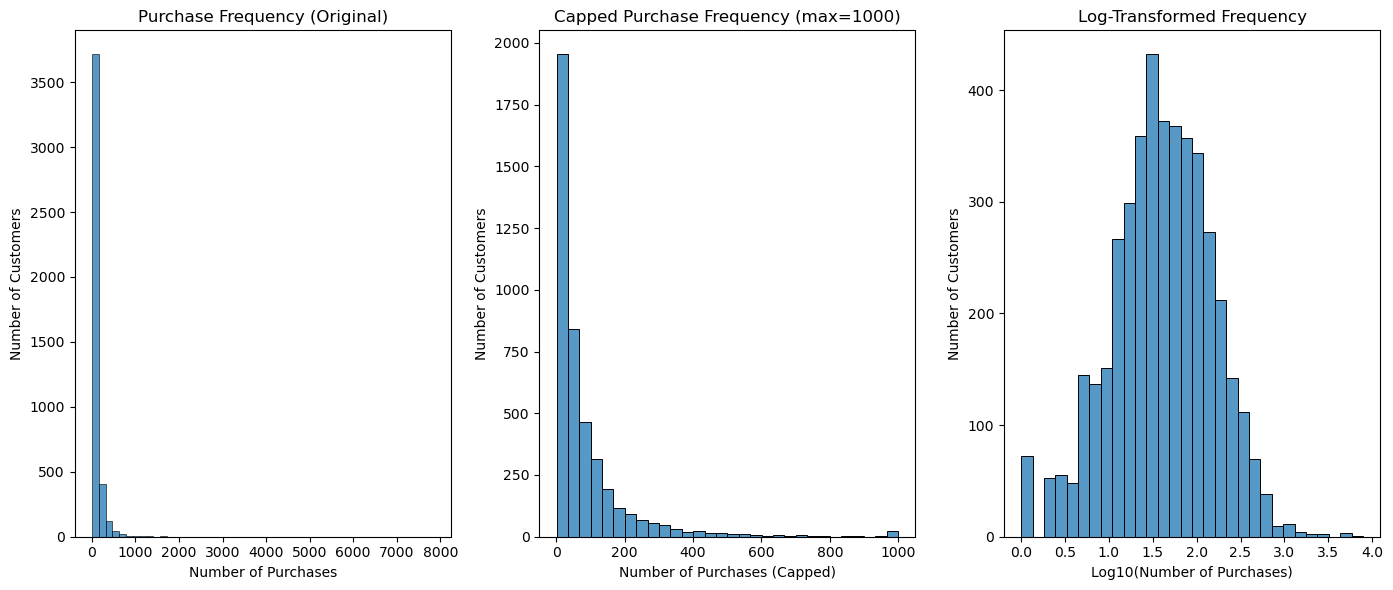

In [11]:
customer_purchase_counts = df['CustomerID'].value_counts()

# create subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 6)) # 2 rows, 2 cols

# 1. og distribution
sns.histplot(customer_purchase_counts, bins=50, kde=False, ax=axes[0])
axes[0].set_title('Purchase Frequency (Original)')
axes[0].set_xlabel('Number of Purchases')
axes[0].set_ylabel('Number of Customers')

# 2. capped distribution
capped_counts = customer_purchase_counts.copy()
capped_counts[capped_counts > 1000] = 1000
sns.histplot(capped_counts, bins=30, kde=False, ax=axes[1])
axes[1].set_title('Capped Purchase Frequency (max=1000)')
axes[1].set_xlabel('Number of Purchases (Capped)')
axes[1].set_ylabel('Number of Customers')

# 3. log-transformed distribution
log_counts = customer_purchase_counts[customer_purchase_counts > 0].apply(lambda x: np.log10(x))
sns.histplot(log_counts, bins=30, kde=False, ax=axes[2])
axes[2].set_title('Log-Transformed Frequency')
axes[2].set_xlabel('Log10(Number of Purchases)')
axes[2].set_ylabel('Number of Customers')
plt.tight_layout()
plt.show()

## Insights:
1. Capped Distribution of Purchase Frequencies shows that most customers make few purchases, with a large drop off past the 0-50 range. Most customers are one time buyers, which makes sense for retail purchases. There are a few frequent buyers, which should be explored because they could be important targets for marketing and advertising.
2. Log-Transformed Distribution of Purchase Frequencies shows a mostly normal distribution, meaning that most customers are in a moderate range of purchase frequencies.



## Geographic Distribution

Number of unique countries: 37
Top 10 countries by transaction count:
Country
United Kingdom    354345
Germany             9042
France              8342
EIRE                7238
Spain               2485
Netherlands         2363
Belgium             2031
Switzerland         1842
Portugal            1462
Australia           1185
Name: count, dtype: int64


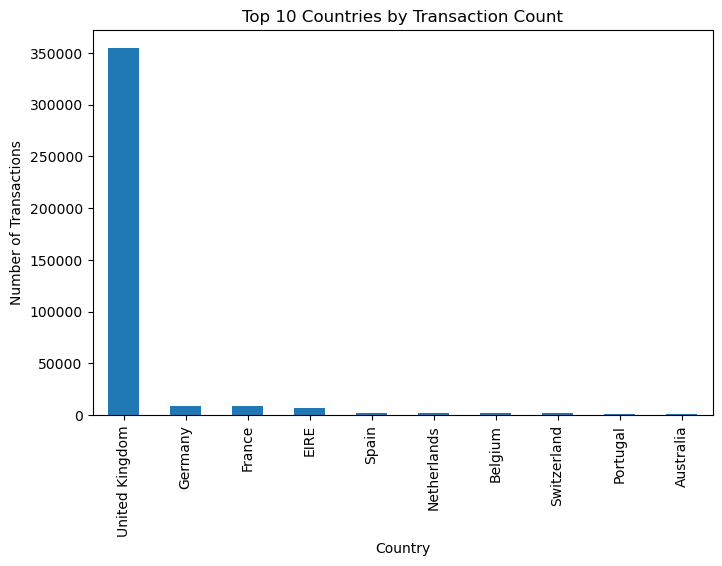

In [12]:
print("Number of unique countries:", df['Country'].nunique())
print("Top 10 countries by transaction count:")
print(df['Country'].value_counts().head(10))

# bar plot
df['Country'].value_counts().head(10).plot(kind='bar', figsize=(8,5))
plt.title('Top 10 Countries by Transaction Count')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.show()

## Insights
The United Kingdom has an overwhelming majority of transactions compared to other countries, meaning that it is the primary market for this dataset. Germany, France, and EIRE (Ireland) have a noticeable number of transactions but are way lower than the UK. The remaining countries have few transaction counts, which suggests limited business activity or customer engagement in those regions.


## Product-Level Analysis (Quantity, UnitPrice, Amount)

Here, I create an Amount feature by multilpying the quantity by the unit price. This will help clustering by providing an additional feature defining the total amount a customer spent. Then, I plotted boxplots of quantity, unit price, and amount revealing extreme outliers. I decided to log transform these features for a better visualization.

Summary Statistics (Quantity, UnitPrice, Amount):
            Quantity      UnitPrice         Amount
count  397924.000000  397924.000000  397924.000000
mean       13.021823       3.116174      22.394749
std       180.420210      22.096788     309.055588
min         1.000000       0.000000       0.000000
25%         2.000000       1.250000       4.680000
50%         6.000000       1.950000      11.800000
75%        12.000000       3.750000      19.800000
max     80995.000000    8142.750000  168469.600000


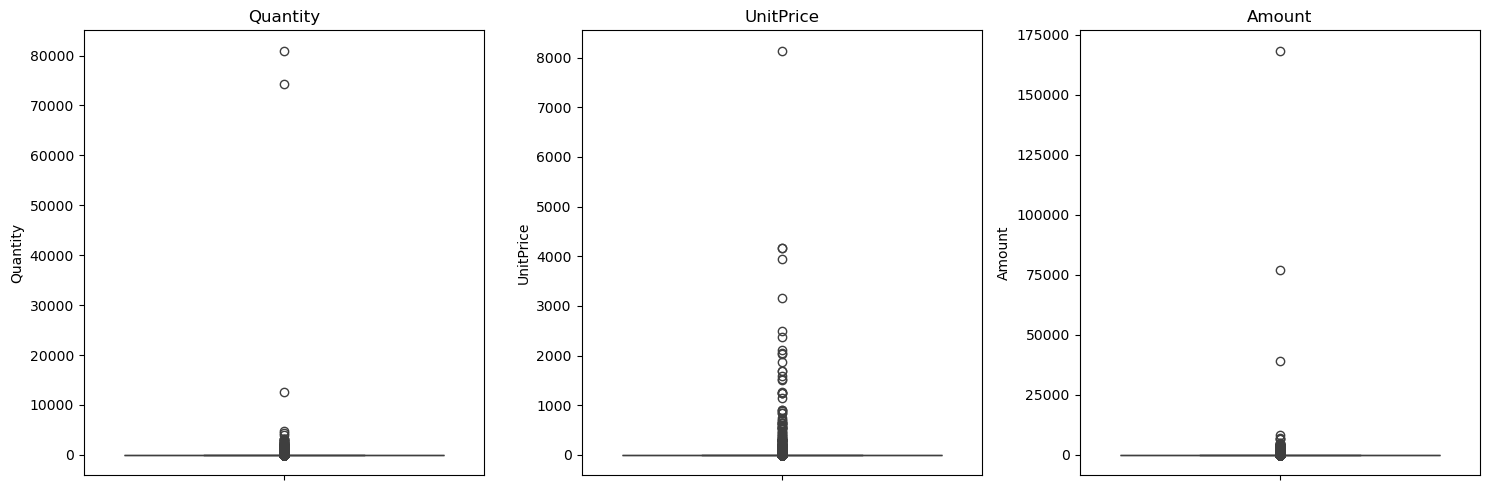

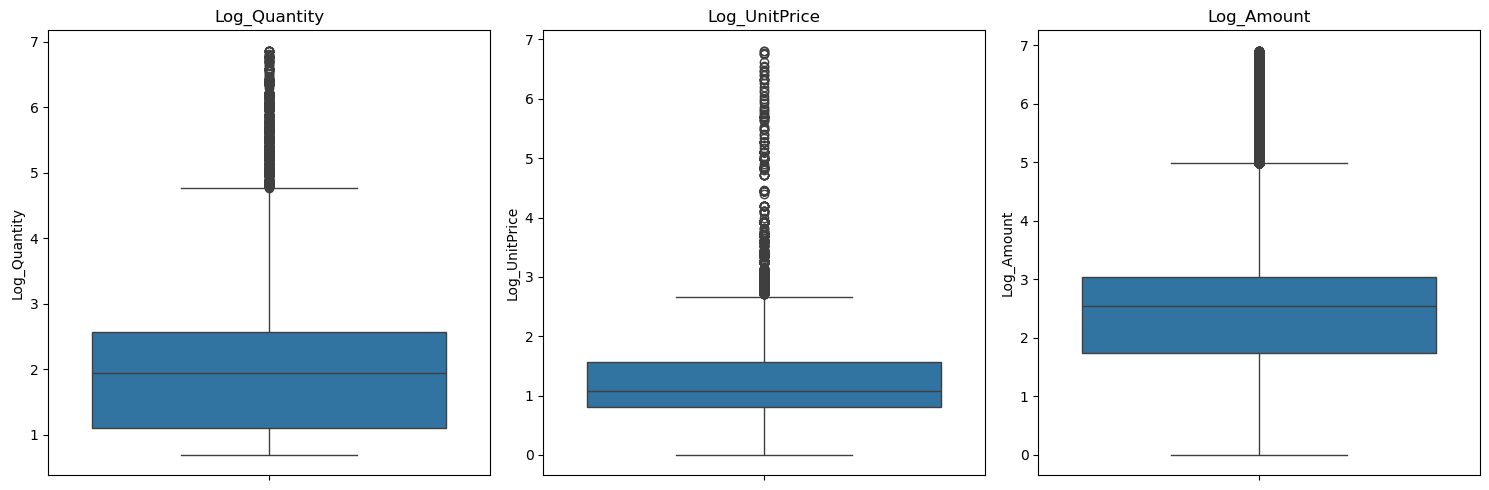

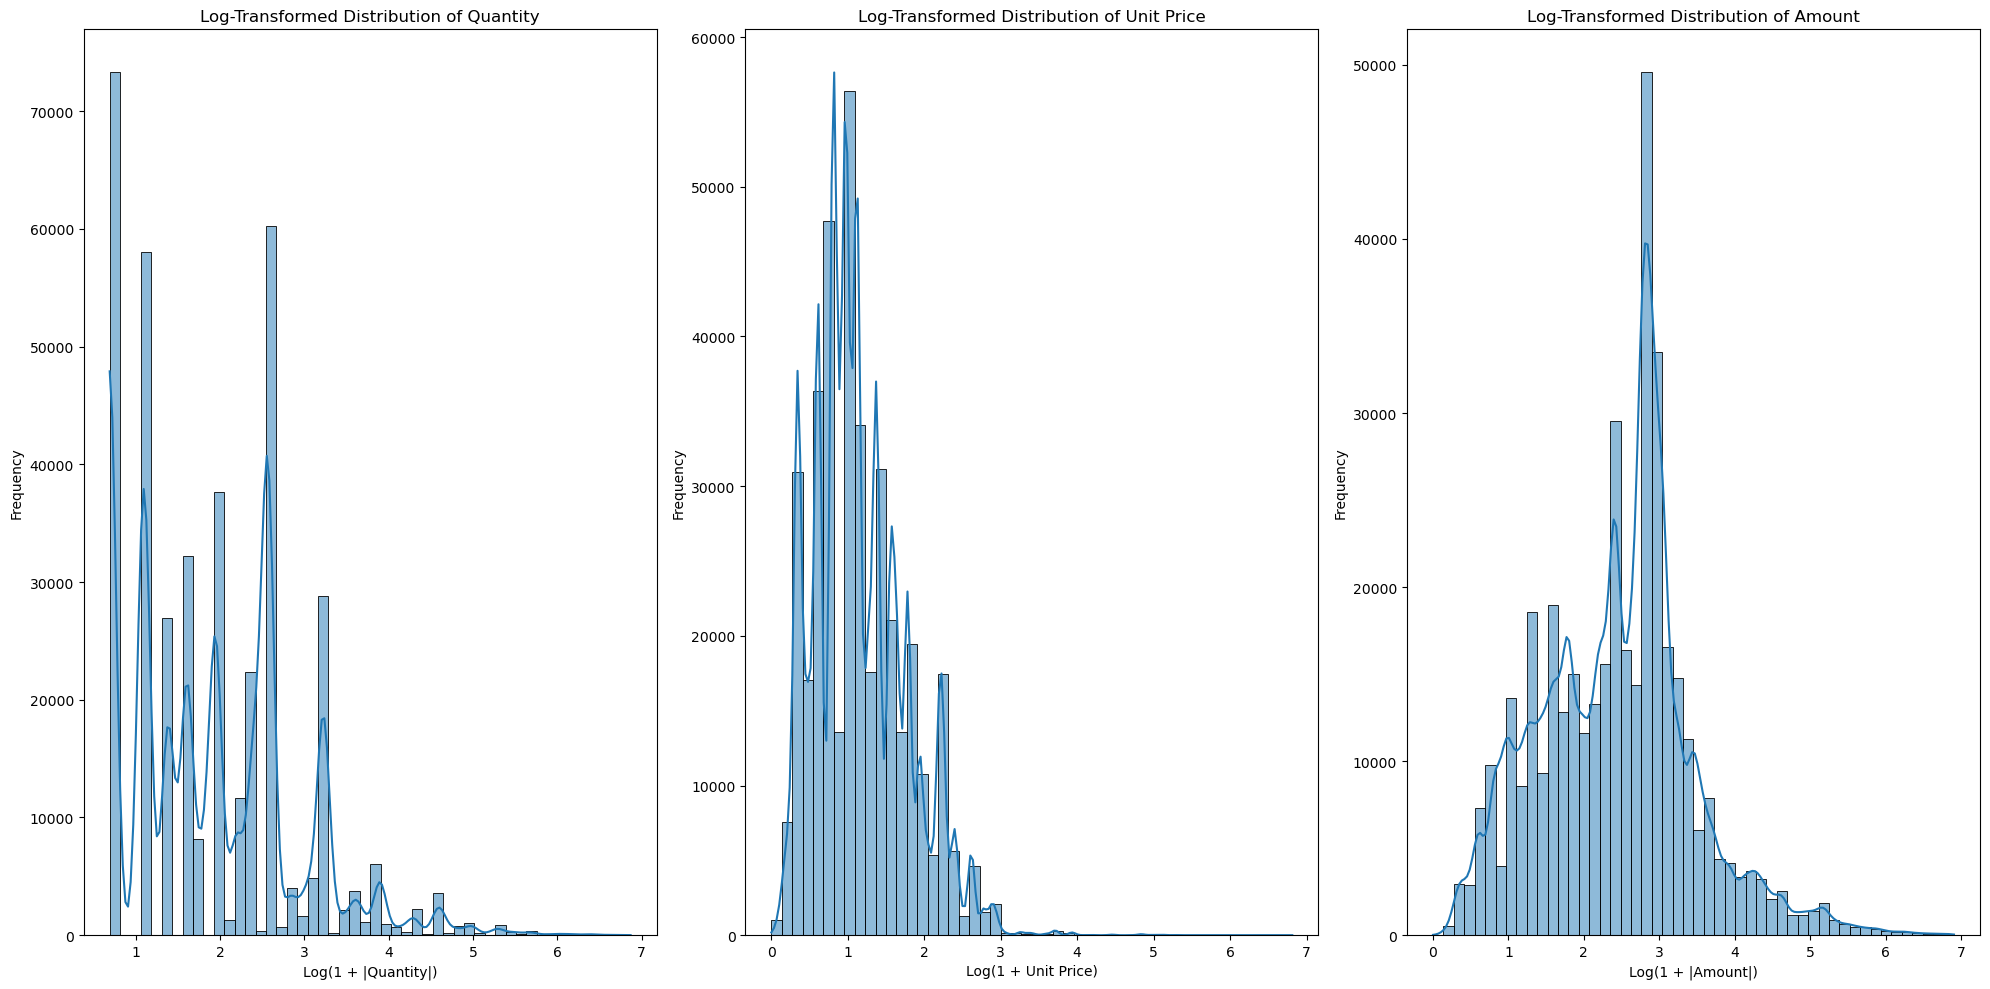

In [13]:
df['Amount'] = df['Quantity'] * df['UnitPrice']
print("Summary Statistics (Quantity, UnitPrice, Amount):")
print(df[['Quantity', 'UnitPrice', 'Amount']].describe())

fig, axes = plt.subplots(1,3, figsize=(15,5))
sns.boxplot(y=df['Quantity'], ax=axes[0]).set_title('Quantity')
sns.boxplot(y=df['UnitPrice'], ax=axes[1]).set_title('UnitPrice')
sns.boxplot(y=df['Amount'], ax=axes[2]).set_title('Amount')
plt.tight_layout()
plt.show()

# remove extreme outliers
filtered_df = df.loc[
    (df['Quantity'] > -1000) & (df['Quantity'] < 1000) &
    (df['UnitPrice'] > 0) & (df['UnitPrice'] < 1000)].copy() # create a copy here to aovid warnings

# log-transformations
filtered_df['Log_Quantity'] = np.log1p(np.abs(filtered_df['Quantity']))
filtered_df['Log_UnitPrice'] = np.log1p(filtered_df['UnitPrice'])

# calc the amount
filtered_df['Amount'] = filtered_df['Quantity'] * filtered_df['UnitPrice']

# filter based on Amount
filtered_df = filtered_df.loc[(filtered_df['Amount'] > -1000) & (filtered_df['Amount'] < 1000)].copy() # create a copy again

# log-transform the Amount
filtered_df['Log_Amount'] = np.log1p(np.abs(filtered_df['Amount']))

# replot the boxplots with log-transformation
fig, axes = plt.subplots(1,3, figsize=(15,5))
sns.boxplot(y=filtered_df['Log_Quantity'], ax=axes[0]).set_title('Log_Quantity')
sns.boxplot(y=filtered_df['Log_UnitPrice'], ax=axes[1]).set_title('Log_UnitPrice')
sns.boxplot(y=filtered_df['Log_Amount'], ax=axes[2]).set_title('Log_Amount')
plt.tight_layout()
plt.show()

# make subplots for filtered and transformed data
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# histogram for log-transformed Quantity
sns.histplot(filtered_df['Log_Quantity'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Log-Transformed Distribution of Quantity')
axes[0].set_xlabel('Log(1 + |Quantity|)')
axes[0].set_ylabel('Frequency')

# histogram for log-transformed UnitPrice
sns.histplot(filtered_df['Log_UnitPrice'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Log-Transformed Distribution of Unit Price')
axes[1].set_xlabel('Log(1 + Unit Price)')
axes[1].set_ylabel('Frequency')

# histogram for log-transformed Amount
sns.histplot(filtered_df['Log_Amount'], bins=50, kde=True, ax=axes[2])
axes[2].set_title('Log-Transformed Distribution of Amount')
axes[2].set_xlabel('Log(1 + |Amount|)')
axes[2].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

## Insights
**Quantity:**
 - Mean (13): The average quantity per transaction is relatively small.
 - Standard Deviation (180): The very high stdev means there is significant variation in the quantity purchased across transactions.
 - Max (80995): This high quantity could be from bulk purchases or data errors.
 - 25th Percentile (2): Many transactions involve single item purchases.
 - Median (6): Half of the transactions involve 6 or fewer items.
 - 75th Percentile (12): 75% of transactions involve fewer than 12 items.

**UnitPrice:**
 - Mean (3): The average price per unit is reasonable but may also be skewed by extreme values.
 - Standard Deviation (22): This moderately high standard deviation means there is price variation across products, which makes sense for this large dataset.
 - Min (0): likely correspond to promotional items, this needs to be examined to decide whether to include these items in the clustering algorithms.
 - Max (8143): High prices could represent premium items, but they should be investigated.
 - 25th Percentile (1.25): Most items are low cost products.
 - Median (1.95): Typical items are inexpensive.
 - 75th Percentile (3.75): 75% of items are below $3.75.

**Amount**
- Mean (22): The average is higher than the 50th percentile (12), indicating a right skewed distribution (a few high value transactions bring the average up).
- Standard Deviation (309): This high standard deviation suggests significant price and quantity variation across products.
- Max (168,470): likely correspond to data entry errors or large corporate purchases.
- Min (0): likely correspond to promotional items, this needs to be examined to decide whether to include these items in the clustering algorithms.
- 25th percentile (5): suggests that most transactions are of small amounts.
- 75th percentile (20): Suggested that a few very large transactions drive the outlier values.

**Boxplots:**
There are significant outliers in Quantity, Unit Price, and Amount. Log-transformed plots also reveal many outliers. These outliers might skew clustering and need careful handling.

**Histograms (bottom row):**
The log-transformed distributions are more normalized, especially for Unit Price and Amount, which supports the use of normalization for clustering or modeling. Quantity remains slightly skewed and will need to be explored more.



## Zero-Priced Items Analysis

In [14]:
# check for anomalies in UnitPrice
zero_price = df[df['UnitPrice'] <= 0]
print(f"Number of Transactions with Zero or Negative Unit Price: {len(zero_price)}")
print(zero_price[['InvoiceNo', 'Quantity', 'Description', 'UnitPrice']])

Number of Transactions with Zero or Negative Unit Price: 40
       InvoiceNo  Quantity                          Description  UnitPrice
9302      537197         1         ROUND CAKE TIN VINTAGE GREEN        0.0
33576     539263         4         ADVENT CALENDAR GINGHAM SACK        0.0
40089     539722        10             REGENCY CAKESTAND 3 TIER        0.0
47068     540372        24              PAPER BUNTING RETROSPOT        0.0
47070     540372        24               PLASTERS IN TIN SKULLS        0.0
56674     541109         1        ORGANISER WOOD ANTIQUE WHITE         0.0
86789     543599        16         FAIRY CAKES NOTEBOOK A6 SIZE        0.0
130188    547417        36  CERAMIC BOWL WITH LOVE HEART DESIGN        0.0
139453    548318         5   MINI CAKE STAND  HANGING STRAWBERY        0.0
145208    548871         2          HEART GARLAND RUSTIC PADDED        0.0
157042    550188         1   CHILDS BREAKFAST SET CIRCUS PARADE        0.0
187613    553000         4              

## Zero Unit Prices
There are 40 transactions with zero unit prices. These entries might be from free promotional items, data entry errors, or missing pricing data. So, I will explore whether these zero-priced items are promotional products or data errors. If they are invalid or irrelevant, I will remove these rows. Otherwise, I will categorize them as promotional items for analysis. I will check if zero prices align with specific dates like Black Friday, holiday seasons, or promotions. Also I will see if certain countries have more zero-priced transactions. Lastly, I will check if specific StockCode values correlate with zero-priced items (marketing giveaways or invalid codes).

In [15]:
zero_price_by_date = df[df['UnitPrice'] == 0].groupby('InvoiceDate').size()
print(zero_price_by_date)

zero_price_by_country = df[df['UnitPrice'] == 0].groupby('Country').size()
print(zero_price_by_country)

zero_price_by_stockcode = (df[df['UnitPrice'] == 0][['StockCode', 'Description']].value_counts().sort_values(ascending=False).head())
print(zero_price_by_stockcode)

InvoiceDate
2010-12-05 14:02:00    1
2010-12-16 14:36:00    1
2010-12-21 13:45:00    1
2011-01-06 16:41:00    2
2011-01-13 15:10:00    1
2011-02-10 13:08:00    1
2011-03-23 10:25:00    1
2011-03-30 12:45:00    1
2011-04-04 14:42:00    1
2011-04-14 18:57:00    1
2011-05-12 15:21:00    1
2011-05-20 14:13:00    1
2011-07-26 12:24:00    1
2011-07-28 17:09:00    1
2011-08-01 11:44:00    1
2011-08-11 11:42:00    1
2011-08-26 14:19:00    4
2011-09-25 12:22:00    1
2011-09-27 09:46:00    1
2011-10-06 08:17:00    1
2011-10-13 12:50:00    1
2011-10-26 14:36:00    1
2011-11-03 11:26:00    1
2011-11-03 11:47:00    1
2011-11-03 13:24:00    1
2011-11-04 11:55:00    1
2011-11-07 13:22:00    1
2011-11-07 16:34:00    2
2011-11-10 11:49:00    2
2011-11-17 19:52:00    1
2011-11-18 10:42:00    1
2011-11-18 13:23:00    1
2011-11-21 11:57:00    1
2011-11-25 15:57:00    1
dtype: int64
Country
Australia          3
EIRE               2
France             1
Germany            2
Netherlands        4
Norway      

Zero-priced items by dates reveal no patterns. Zero-priced items by country do not reveal any clear patterns, esepcially since the dataset is majority UK purchases. Certain StockCode values (M) appear frequently with zero prices. This code is for Manuals. Since there are only 40 zero-priced items, removing them will not negatively impact my results.

In [16]:
# remove zero-priced items from the main dataset to prevent skewed clusters
df = df[df['UnitPrice'] > 0]

Checking for the most and least popular items can inform the business which products they should focus or ignore marketing for. I decdied to find the most and least popular items by their total quantity sold.

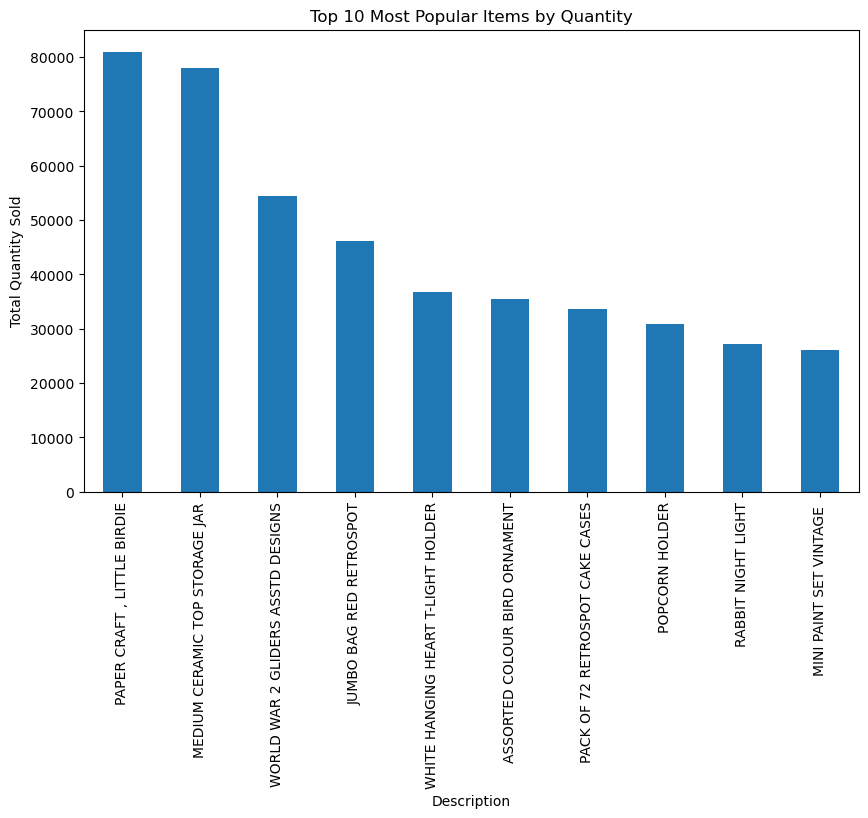

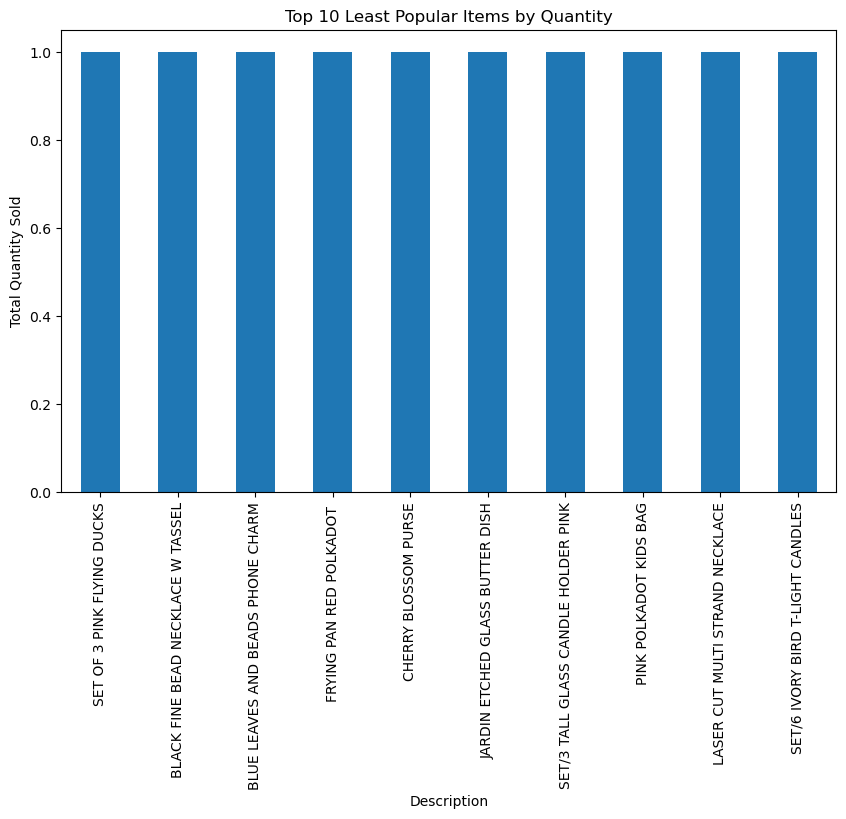

In [17]:
# top 10 most popular items
popular_items = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
popular_items.plot(kind='bar', figsize=(10, 6), title='Top 10 Most Popular Items by Quantity')
plt.ylabel('Total Quantity Sold')
plt.show()

# top 10 least popular items (excluding negatives/returns)
least_popular_items = df.groupby('Description')['Quantity'].sum().sort_values(ascending=True).head(10)
# bar plot for least popular items
least_popular_items.plot(kind='bar', figsize=(10, 6), title='Top 10 Least Popular Items by Quantity')
plt.ylabel('Total Quantity Sold')
plt.show()

## Time-based/Seasonal Analysis

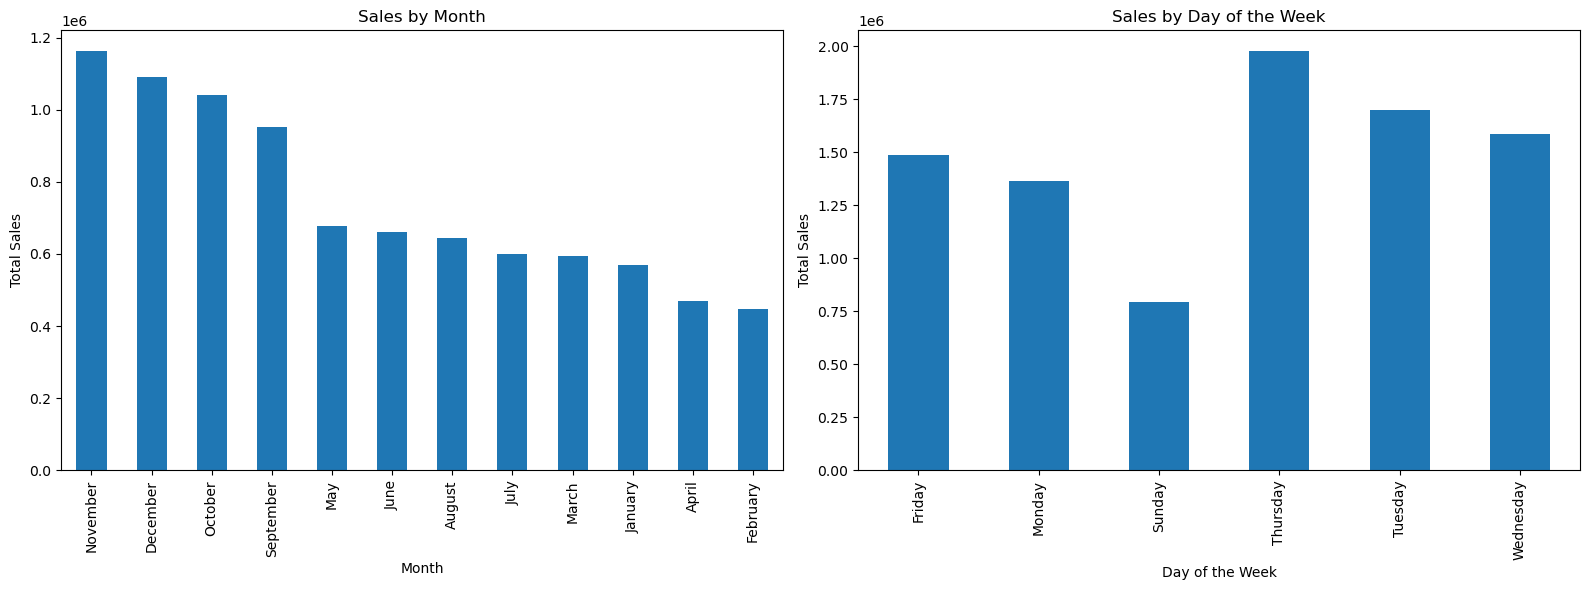

In [18]:
# monthly sales data
monthly_sales = df.groupby('Month', observed=False)['Amount'].sum().sort_values(ascending=False)
# day-of-week sales data
weekday_sales = df.groupby('DayOfWeek', observed=False)['Amount'].sum()

# make subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns
# monthly sales plot
monthly_sales.plot(kind='bar', ax=axes[0])
axes[0].set_title('Sales by Month')
axes[0].set_ylabel('Total Sales')
axes[0].set_xlabel('Month')
# day-of-week sales plot
weekday_sales.plot(kind='bar', ax=axes[1])
axes[1].set_title('Sales by Day of the Week')
axes[1].set_ylabel('Total Sales')
axes[1].set_xlabel('Day of the Week')
plt.tight_layout()
plt.show()

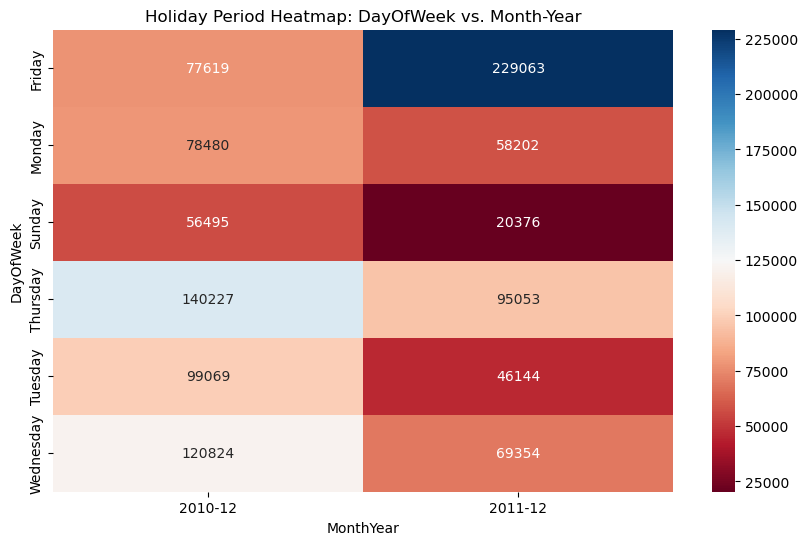

In [19]:
# subset to holiday days
holiday_df = df[df['HolidayPeriod'] == 'Holiday Season'].copy()

# since 2 years, do Month+Year: dt.to_period('M') changes InvoiceDate col to monthly period (2011-12-15 --> 2011-12)
holiday_df['MonthYear'] = holiday_df['InvoiceDate'].dt.to_period('M').astype(str)
holiday_pivot = holiday_df.pivot_table(values='Amount', index='DayOfWeek', columns='MonthYear', aggfunc='sum', observed=False)

plt.figure(figsize=(10,6))
sns.heatmap(holiday_pivot, cmap='RdBu', annot=True, fmt='.0f')
plt.title('Holiday Period Heatmap: DayOfWeek vs. Month-Year')
plt.show()

## Insights from the Time-Based Analysis:
**Monthly Sales:** November and December have the highest sales, likely due to the holiday season. There are low sales in February and April. These months might be non peak season, with fewer shopping events or promotions.

**Day of the Week:**

Thursday and Tuesday have the highest sales. This could just be regular midweek shopping. Sunday is the lowest, likely due to store closures or reduced hours in certain areas.

**Holiday Period Heatmap:**

Sales are highest on Fridays during the holiday season, likely due to holiday shopping and gift purchases after the work week. Sundays consistently show the least activity across both December 2010 and December 2011. Sales on Thursdays and Tuesdays also show strong performance during December. This means that the holiday season, particularly Fridays, is a critical period for sales.



## Additional Steps Before Clustering

Given the high holiday-season volume, I decided to focus on holiday shoppers. First, I built aggregated features per customers in that holiday window for clustering. I then added an average holiday amount feature in order to give insights on how customers spend on each transaction. This will improve clustering quality by giving an additional dimensions to segregate customers by. Additionally, it will help balance the feature significance since certain customers may have a very high total amount spent.

In the following cell, I remove outliers to reduce their influence. Since outliers were signifcantly skewing my clustering results due to the distance based nature of k-means and hierarchial clustering techbnniques, replacing extreme values with these threholds will make sure the clusters are based on typical customer spending habits. Capping the extreme values makes the clusters more representative of the overall population. This will allow me to make more meaningful groupings.


In [20]:
# subset only holiday purchases (including Black Friday and December holiday season)
holiday_only_df = df[df['HolidayPeriod'].isin(['Black Friday', 'Holiday Season'])].copy()

# aggregate features at the customer level (only holiday rows)
customer_holiday_data = holiday_only_df.groupby('CustomerID').agg({
    'Amount': 'sum', # total holiday spending
    'Quantity': 'sum', # total holiday quantity
    'InvoiceNo': 'nunique' # number of holiday invoices
}).reset_index()

# rename columns for clarity
customer_holiday_data.columns = ['CustomerID', 'HolidayTotalAmount', 'HolidayTotalQuantity', 'HolidayFrequency']

# make an additional AvgHolidayAmount feature
customer_holiday_data['AvgHolidayAmount'] = (customer_holiday_data['HolidayTotalAmount'] / customer_holiday_data['HolidayFrequency'])
print("Holiday only customer level data:")
print(customer_holiday_data.head())

Holiday only customer level data:
   CustomerID  HolidayTotalAmount  HolidayTotalQuantity  HolidayFrequency  \
0     12347.0              936.61                   511                 2   
1     12348.0              892.80                  1254                 1   
2     12349.0             1757.55                   631                 1   
3     12356.0               58.35                     5                 1   
4     12358.0              683.20                   148                 1   

   AvgHolidayAmount  
0           468.305  
1           892.800  
2          1757.550  
3            58.350  
4           683.200  


In [21]:
def outlier_thresholds(dataframe, variable, q1=0.03, q3=0.97):
    quartile1 = dataframe[variable].quantile(q1)
    quartile3 = dataframe[variable].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return up_limit, low_limit

def replace_with_threshold(dataframe, variable):
    up_limit, low_limit = outlier_thresholds(dataframe, variable)
    dataframe[variable] = dataframe[variable].astype(float)
    dataframe.loc[dataframe[variable] > up_limit, variable] = up_limit
    dataframe.loc[dataframe[variable] < low_limit, variable] = low_limit

outlier_cols = ['HolidayTotalAmount', 'HolidayTotalQuantity', 'HolidayFrequency', 'AvgHolidayAmount']
for col in outlier_cols:
    replace_with_threshold(customer_holiday_data, col)

print("Data after outlier removal:")
print(customer_holiday_data[outlier_cols].describe())

Data after outlier removal:
       HolidayTotalAmount  HolidayTotalQuantity  HolidayFrequency  \
count         1941.000000           1941.000000       1941.000000   
mean           735.291097            421.962648          1.877383   
std           1207.405940            702.778528          1.646351   
min             15.000000              1.000000          1.000000   
25%            205.860000            104.000000          1.000000   
50%            362.790000            208.000000          1.000000   
75%            727.250000            441.000000          2.000000   
max           8853.351000           4933.500000         13.500000   

       AvgHolidayAmount  
count       1941.000000  
mean         357.036247  
std          356.376308  
min           15.000000  
25%          170.320000  
50%          271.825000  
75%          397.500000  
max         2949.813500  


Here, I scale all the features before clustering to make sure that all features contribute equally to the process, avoiding bias from features with larger numerical ranges. The Min-Max scaler is a good option because it normalizes data to 0 to 1, preserving relative distances between points. In agglomerative clustering using the cosine metric, the similarity is based on the angle between vectors, not just the magnitude. Zero-row vectors (rows with all features equal to zero) cause issues because cosine similarity is undefined for zero vectors, as the dot product with any vector is zero, and division by zero occurs. Filtering out zero-priced items beforehand leaves zero-row vectors, which need to be excluded to avoid errors. Removing these rows makes sure the clustering algorithm functions without numerical instability errors.

In [22]:
holiday_features = ['HolidayTotalAmount', 'HolidayTotalQuantity', 'HolidayFrequency', 'AvgHolidayAmount']

X = customer_holiday_data[holiday_features].copy()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# identify zero vector rows
zero_vector_rows = (X_scaled == 0).all(axis=1)
# filter out zero vectors
X_scaled_no_zeros = X_scaled[~zero_vector_rows]
customer_holiday_data= customer_holiday_data.loc[~zero_vector_rows].reset_index(drop=True)

# 3. Model Building and Analysis

Below, I evaluate agglomerative clustering with multiple linkage methods (ward, complete, average, single) and distance metrics (euclidean, manhattan, cosine). I fix n_clusters=3 to group holiday shoppers into the three following groups: non-holiday shoppers, moderate holiday shoppers, and frequent holiday shoppers.


evaluate_clustering: Calculates the three key metrics: silhouette score (higher = better separation), Calinski-Harabasz index (higher = better), Davies-Bouldin score (lower = better).

Iterate Over Linkage & Distance: I test all combinations of linkage (complete, average, single, ward) and distance metrics (euclidean, manhattan, cosine) to find the best silhouette score.

Best Model: The model with the highest silhouette score is saved. I then plot it in 2D PCA space for a visual of how the clusters are distributed.

In [23]:
def evaluate_clustering(labels, data):
    silhouette = silhouette_score(data, labels)
    calinski = calinski_harabasz_score(data, labels)
    davies = davies_bouldin_score(data, labels)
    return silhouette, calinski, davies

linkage_methods = ['ward', 'complete', 'average', 'single']
distance_metrics = ['euclidean', 'manhattan', 'cosine']

best_hierarchical_score = -1
best_hier_model = None
best_hier_labels = None
best_linkage = None
best_metric = None

for linkage in linkage_methods:
    for metric in distance_metrics:
        # ward linkage only supports euclidean distance
        if linkage == 'ward' and metric != 'euclidean':
            continue

        start_time = time.time()
        # fix n_clusters=3
        model = AgglomerativeClustering(n_clusters=3, linkage=linkage, metric=metric)
        labels = model.fit_predict(X_scaled_no_zeros)
        elapsed = time.time() - start_time

        silhouette, calinski, davies = evaluate_clustering(labels, X_scaled_no_zeros)
        print(f"Agglomerative ({linkage}, {metric}) "
              f"- Silhouette: {silhouette:.3f}, "
              f"Calinski-Harabasz: {calinski:.3f}, "
              f"Davies-Bouldin: {davies:.3f}, "
              f"Time: {elapsed:.3f}s")

        # track best by silhouette
        if silhouette > best_hierarchical_score:
            best_hierarchical_score = silhouette
            best_hier_model = model
            best_hier_labels = labels
            best_linkage = linkage
            best_metric = metric

print("\nBest Hierarchical Clustering Model:")
print(f"- Linkage: {best_linkage}")
print(f"- Distance Metric: {best_metric}")
print(f"- Silhouette Score: {best_hierarchical_score:.3f}")
# store these best labels in customer_holiday_data
customer_holiday_data['HierCluster'] = best_hier_labels
print("\nHierarchical Clustering Cluster Counts:")
print(customer_holiday_data['HierCluster'].value_counts())

Agglomerative (ward, euclidean) - Silhouette: 0.560, Calinski-Harabasz: 1589.799, Davies-Bouldin: 1.041, Time: 0.031s
Agglomerative (complete, euclidean) - Silhouette: 0.770, Calinski-Harabasz: 987.833, Davies-Bouldin: 0.832, Time: 0.029s
Agglomerative (complete, manhattan) - Silhouette: 0.748, Calinski-Harabasz: 1113.258, Davies-Bouldin: 0.691, Time: 0.027s
Agglomerative (complete, cosine) - Silhouette: 0.341, Calinski-Harabasz: 214.221, Davies-Bouldin: 2.292, Time: 0.027s
Agglomerative (average, euclidean) - Silhouette: 0.763, Calinski-Harabasz: 969.417, Davies-Bouldin: 0.642, Time: 0.030s
Agglomerative (average, manhattan) - Silhouette: 0.791, Calinski-Harabasz: 663.907, Davies-Bouldin: 0.577, Time: 0.035s
Agglomerative (average, cosine) - Silhouette: 0.205, Calinski-Harabasz: 230.171, Davies-Bouldin: 1.743, Time: 0.028s
Agglomerative (single, euclidean) - Silhouette: 0.729, Calinski-Harabasz: 24.311, Davies-Bouldin: 0.266, Time: 0.012s
Agglomerative (single, manhattan) - Silhouette

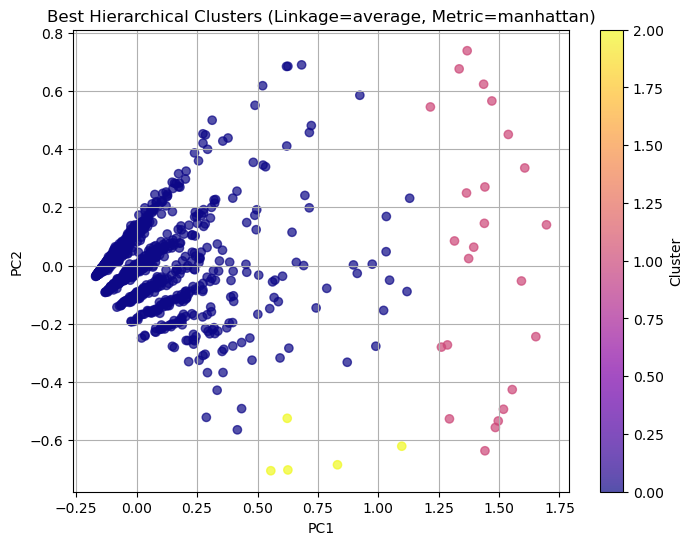

In [24]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_no_zeros)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_hier_labels, cmap='plasma', alpha=0.7)
plt.title(f"Best Hierarchical Clusters (Linkage={best_linkage}, Metric={best_metric})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

**K-Means Clustering**

Next, I compare K-Means with the same number of clusters (k=3) to see whether it forms meaningful segments for our holiday shoppers.

Silhouette Score: Measures how distinct each cluster is.
Calinski-Harabasz: Rewards clusters that are compact and well-separated.
Davies-Bouldin: Penalizes clusters that overlap or are too close. PCA Visualization: I plot the data into 2D principal components to visualize the clusters. The red “X” marks are the cluster centroids in PCA space.

In [25]:
start_time = time.time()

# k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled_no_zeros)
end_time = time.time()

# store labels in your customer data
customer_holiday_data['HolidayCluster'] = cluster_labels
print("\nK-means Cluster counts:")
print(customer_holiday_data['HolidayCluster'].value_counts())

# calc silhouette score
silhouette = silhouette_score(X_scaled_no_zeros, cluster_labels)
print(f"\nK-means Silhouette Score for k=3: {silhouette:.3f}")
# calc Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(X_scaled_no_zeros, cluster_labels)
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")
# calc Davies-Bouldin Score
davies_bouldin = davies_bouldin_score(X_scaled_no_zeros, cluster_labels)
print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")
execution_time = end_time - start_time
print(f"Clustering Execution Time: {execution_time:.3f} seconds")


K-means Cluster counts:
HolidayCluster
0    1613
2     287
1      40
Name: count, dtype: int64

K-means Silhouette Score for k=3: 0.621
Calinski-Harabasz Index: 1893.315
Davies-Bouldin Score: 0.884
Clustering Execution Time: 0.166 seconds


C:\Users\mattg\anaconda3\envs\tf_gpu_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


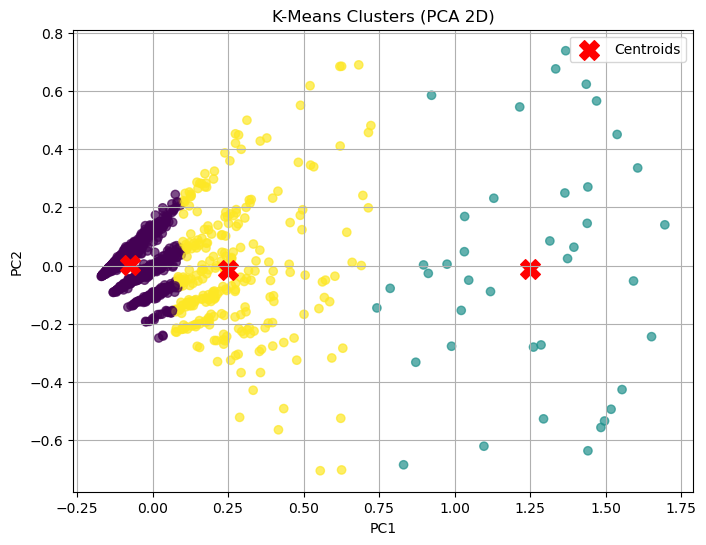

In [26]:
# reduce to 2 principal components for 2D plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_no_zeros)

plt.figure(figsize=(8, 6))
# plot each sample in 2D PCA space, colored by cluster label
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)

# plot the cluster centroids (in PCA space)
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=200, c='red', marker='X', label='Centroids')

plt.title("K-Means Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

## **Clustering Insights**
**Metric Comparisons**

 - Silhouette Score:
   - Hierarchical, average, manhattan might yield a higher silhouette (0.791) vs. K-Means (0.621), suggesting more distinct or irregularly shaped clusters that K-Means doesn't capture well.

 - Calinski-Harabasz Index (higher = better separation):
   - K-Means does better here, scoring higher (1893) vs. hierarchical (664).

 - Davies-Bouldin Score (lower = better):
   - Hierarchial, average, manhattan slightly outperforms hierarchical (0.884 vs. 0.577).

**Why Hierarchical May Appear “Better”**

1. Flexible cluster shapes: Hierarchical clustering doesn't assume spherical distributions, allowing it to adapt to complex structures.
2. More sensitive to small differences: Linkage methods like complete or average isolate small and dense subgroups.

**Why K-Means Could Still Be Preferable**
1. Balanced clusters: K-Means distributes points more evenly, whereas hierarchical produces tiny clusters (a cluster with just 5 customers).
2. Efficiency & Speed: K-Means is faster than hierarchical for large datasets.
3. Frequent itemset mining: Since I need relatively balanced clusters for frequent itemset mining, K-Means yields more meaningful groups. A tiny cluster from hierarchical lacks enough transactions to discover frequent patterns.

**Final Decision for Holiday Segmentation**

Given that I want balanced segments for holiday shopper analysis and itemset mining, **K-Means** is a practical choice despite a lower silhouette score. It ensures each cluster has enough transactions to give me meaningful association rules and targeted marketing strategies.

In [27]:
cluster_stats = customer_holiday_data.groupby('HolidayCluster')[['HolidayTotalAmount', 'HolidayFrequency']].mean()
print(cluster_stats)

                HolidayTotalAmount  HolidayFrequency
HolidayCluster                                      
0                       368.815443          1.409795
1                      7456.320750          7.775000
2                      1860.741742          3.686411


In [28]:
cluster_label_map = {0: "Non-Holiday Shoppers", 1: "Frequent Holiday Shoppers", 2: "Moderate Holiday Shoppers"}
customer_holiday_data['HolidayClusterName'] = (customer_holiday_data['HolidayCluster'].map(cluster_label_map))

## **Frequent Itemset Mining**
**Key Terminology**
 - Antecedent (“IF”): A set of items that appear in a transaction together.
    - In “IF {bread, milk} THEN {butter},” the antecedent is {bread, milk}.
 - Consequent (“THEN”): A set of items predicted to appear given the antecedent.
  - In “IF {bread, milk} THEN {butter},” the consequent is {butter}.
 - Support: Probability of transactions containing both antecedent and consequent. Typical thresholds are 1 to 10%.
 - Confidence: Probability of the consequent given the antecedent. Typically, we want between 50 to 100%.
 - Lift: Measures how many times more likely the consequent is to occur with the antecedent than by chance alone. Values >1 indicate a positive correlation.

Here, I use FPGrowth (Frequent Pattern Growth) to efficiently find itemsets with at least a certain min_support. Then, association_rules is applied to generate rules that meet a min_threshold for confidence.

**Details:**

1. Cluster Subset: I only look at transactions for the customers in each cluster.
2. Basket Construction:
 - Rows = invoices.
 - Columns = product descriptions.
 - Cells = 1 (True) if the invoice contains the item, 0 (False) if not.
3. Pruning Rare Items: Items that appear in fewer than 10 invoices are removed to reduce noise and memory usage.
4. FPGrowth: Finds sets of items that co-occur in transactions with min_support >= 0.05.
5. Association Rules: For each frequent itemset, generate rules that meet a minimum confidence (20%).

Result: A rules_sorted df containing antecedents, consequents, support, confidence, and lift. Higher confidence and lift indicate stronger co-purchase patterns.

In [29]:
cluster_rules = {}
for cluster_id in sorted(customer_holiday_data['HolidayCluster'].unique()):
    # fetch the string name from the map
    cluster_name = cluster_label_map.get(cluster_id, f"Unknown Cluster {cluster_id}")
    print(f"\nCLUSTER {cluster_id} ({cluster_name}):")

    # 1. subset customers
    cluster_customers = customer_holiday_data.loc[customer_holiday_data['HolidayCluster'] == cluster_id, 'CustomerID']

    # 2. subset holiday transactions for these cluster customers
    cluster_holiday_df = holiday_only_df[holiday_only_df['CustomerID'].isin(cluster_customers)].copy()

    if cluster_holiday_df.empty:
        print(f"No transactions for cluster {cluster_id}")
        continue

    # 3. build the basket
    basket = (
        cluster_holiday_df
        .groupby(['InvoiceNo', 'Description_mode'])['Quantity']
        .sum().unstack().fillna(0)
        .applymap(lambda x: 1 if x > 0 else 0)
        .astype(bool))

    # prune rare items: remove columns with fewer than 10 occurrences
    item_counts = basket.sum(axis=0) # sum across transactions (rows)
    frequent_items = item_counts[item_counts >= 10].index
    basket = basket[frequent_items]

    print("Basket shape after pruning rare items:", basket.shape)
    if basket.shape[1] == 0:
        print(f"All items too rare for cluster {cluster_id}, skipping.")
        continue

    # 4. use FPGrowth (for better memory management) or Apriori
    min_support = 0.05
    frequent_itemsets = fpgrowth(basket, min_support=min_support, use_colnames=True)

    if frequent_itemsets.empty:
        print(f"No frequent itemsets for cluster {cluster_id} at min_support={min_support}.")
        continue

    print(f"Found {len(frequent_itemsets)} frequent itemsets.")

    # 5. association rules
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2, num_itemsets=2)

    if rules.empty:
        print(f"No rules for cluster {cluster_id}.")
        continue

    rules_sorted = rules.sort_values(by='confidence', ascending=False)
    cluster_rules[cluster_id] = rules_sorted
    print(rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


CLUSTER 0 (Non-Holiday Shoppers):
Basket shape after pruning rare items: (2274, 1268)
Found 25 frequent itemsets.
                           antecedents                          consequents  \
1  (PAPER CHAIN KIT VINTAGE CHRISTMAS)    (PAPER CHAIN KIT 50'S CHRISTMAS )   
0    (PAPER CHAIN KIT 50'S CHRISTMAS )  (PAPER CHAIN KIT VINTAGE CHRISTMAS)   

    support  confidence      lift  
1  0.051891    0.614583  5.119277  
0  0.051891    0.432234  5.119277  

CLUSTER 1 (Frequent Holiday Shoppers):
Basket shape after pruning rare items: (443, 270)
Found 33 frequent itemsets.
                             antecedents  \
4            (HAND WARMER RED RETROSPOT)   
2  (KNITTED UNION FLAG HOT WATER BOTTLE)   
5               (HAND WARMER UNION JACK)   
0       (RED WOOLLY HOTTIE WHITE HEART.)   
3   (WHITE HANGING HEART T-LIGHT HOLDER)   
1   (WHITE HANGING HEART T-LIGHT HOLDER)   

                             consequents   support  confidence       lift  
4               (HAND WARMER UNION J

## Simple Rule-Based Recommender System
Overview:

Next, I make a simple “if-then” recommender system based on the discovered association rules. This takes the customer's current items as input, filters rules to those whose antecedents are subsets of the customer's items, collects consequents (“then” items) as recommendations, and ranks them by confidence and returns the top N suggestions.

Logic:

1. Current Items: Suppose the user already has {“PAPER CHAIN KIT VINTAGE CHRISTMAS”}.
2. Match Antecedents: If your rule is (“PAPER CHAIN KIT VINTAGE CHRISTMAS”) -> (“PAPER CHAIN KIT 50'S CHRISTMAS”), and the customer's item set includes the antecedent, the system recommends the consequent.
3. Confidence Ranking: I assume items from higher confidence rules are more relevant to the user.
4. Final Recommendation List: I deduplicate and return up to top_n items.

This is useful because a user who has “PAPER CHAIN KIT VINTAGE CHRISTMAS” might also want “PAPER CHAIN KIT 50'S CHRISTMAS.” This approach is clear and good for market basket style suggestions. It essentially automates looking through each frequent itemset above.

In [30]:
def recommend_items(current_items, rules_sorted, top_n=20):
    # filter rules where antecedents is a subset of current_items
    filtered_rules = rules_sorted[rules_sorted['antecedents'].apply(lambda ante: ante.issubset(current_items))]
    # sort by highest confidence or lift (already sorted by conf in rules_sorted)
    filtered_rules = filtered_rules.sort_values('confidence', ascending=False)

    recommended = []
    for _, row in filtered_rules.iterrows():
        for item in row['consequents']:
            if item not in current_items:
                recommended.append(item)

    # remove duplicates while preserving order
    recommended = list(dict.fromkeys(recommended))
    return recommended[:top_n]

In [31]:
# example usage: suppose a user from cluster 0 has these items:
user_items = {"PAPER CHAIN KIT VINTAGE CHRISTMAS"}

rules_cluster_0 = cluster_rules.get(0, pd.DataFrame())
if not rules_cluster_0.empty:
    recs = recommend_items(user_items, rules_cluster_0, top_n=20)
    print("\nRecommendations for a user with items:", user_items)
    print(recs)

# example usage: suppose a user from cluster 1 has these items:
user_items = {"HAND WARMER RED RETROSPOT", "KNITTED UNION FLAG HOT WATER BOTTLE"}

rules_cluster_1 = cluster_rules.get(1, pd.DataFrame())
if not rules_cluster_1.empty:
    recs = recommend_items(user_items, rules_cluster_1, top_n=10)
    print("\nRecommendations for a user with items:", user_items)
    print(recs)

# example usage: suppose a user from cluster 2 has these items:
user_items = {"ALARM CLOCK BAKELIKE GREEN"}

rules_cluster_2 = cluster_rules.get(2, pd.DataFrame())
if not rules_cluster_2.empty:
    recs = recommend_items(user_items, rules_cluster_2, top_n=20)
    print("\nRecommendations for a user with items:", user_items)
    print(recs)


Recommendations for a user with items: {'PAPER CHAIN KIT VINTAGE CHRISTMAS'}
["PAPER CHAIN KIT 50'S CHRISTMAS "]

Recommendations for a user with items: {'HAND WARMER RED RETROSPOT', 'KNITTED UNION FLAG HOT WATER BOTTLE'}
['HAND WARMER UNION JACK', 'WHITE HANGING HEART T-LIGHT HOLDER']

Recommendations for a user with items: {'ALARM CLOCK BAKELIKE GREEN'}
['ALARM CLOCK BAKELIKE RED ']


## Implicit Collaborative Filtering Recommender System

In many real-world scenarios, we might not have users explicitly rating products with 1 to 5 stars. Instead, we only see which items they purchased or didn't purchase. This binary (1 or 0) is the implicit feedback. If a user bought an item, it suggests some level of interest and if not, it means no preference.

Traditional collaborative filtering (CF) often relies on explicit ratings to calculate user-item similarities or perform matrix factorization. However, libraries like implicit handle these binary purchase matrices, allowing me to build a latent factor model without ratings.

This was included because implicit collaborative filtering can adapt to new user preferences and recommend entirely new items, while the rule-based approach might require updates to the rules if new products are introduced. Here is how it works:

1. User-Item Matrix (rows = users, columns = items):

 - In this code, each row corresponds to a CustomerID, and each column to a product description, with cell values set to 1 if the user purchased that product and 0 if not.
 - This matrix can be large, so I convert it to a sparse format (csr_matrix).

2. Alternating Least Squares (ALS) from implicit:

 - ALS factorizes the user-item matrix into latent factors, representing user preferences and item attributes.
 - It uses implicit feedback (purchase history) and confidence weighting to model interactions effectively.
 - Recall@N is used to evaluate the recommendations, as it measures how well the model captures relevant items among the top-N recommendations. This is a critical metric for recommender systems prioritizing relevance.

 3. Hyperparameter Tuning and Validation

 - The data is split into training and validation sets using train_val_split.
 - Optuna is used to tune ALS hyperparameters like factors, regularization,  and iterations to maximize recall@N on the validation set.


4. Cluster Integration:

 - I do this for each holiday cluster, building a cluster-specific user-item matrix. This ensures recommendations are tailored to the patterns within that cluster.
 - Each cluster's ALS model is trained using the best hyperparameters found during tuning, ensuring optimal performance across different customer segments.

 5. Recommendations:

- For demonstration, the model generates  recommendations for a sample customer within each cluster, listing their past purchases and suggesting new items with relevance scores.

## Hyperparameter Tuning with Recall@N

In [32]:
def train_val_split(user_item_csr, val_ratio=0.2):
    # 1. convert csr matrix to coo format for easy iteration
    coo = user_item_csr.tocoo()
    interactions = list(zip(coo.row, coo.col))
    np.random.shuffle(interactions)

    # 2. split into train and validation interactions
    val_size = int(len(interactions) * val_ratio)
    val_interactions = interactions[:val_size]
    train_interactions = interactions[val_size:]

    # 3. create train and validation csr matrices
    train_row, train_col = zip(*train_interactions)
    val_row, val_col = zip(*val_interactions)

    train_csr = csr_matrix((np.ones(len(train_row)), (train_row, train_col)), shape=user_item_csr.shape)
    val_csr = csr_matrix((np.ones(len(val_row)), (val_row, val_col)), shape=user_item_csr.shape)
    return train_csr, val_csr

def recall_at_n(model, train_csr, val_csr, N=5):
    # 1. convert validation set to coo format and get all (user, item) pairs
    val_coo = val_csr.tocoo()
    val_positives = list(zip(val_coo.row, val_coo.col))
    total_recall = 0
    num_users = 0

    for user, _ in val_positives:
        # 2. skip invalid users if necessary
        if user >= train_csr.shape[0]:
            continue
        num_users += 1

        # 3. get top-n recommendations for the user
        recommended = model.recommend(userid=user, user_items=train_csr[user], N=N, filter_already_liked_items=False)
        recommended_items = set(recommended[0])  # extract item indices

        # 4. count how many true items are in the top-n recommendations
        true_items = set(val_csr[user].nonzero()[1])
        total_recall += len(recommended_items & true_items) / len(true_items)

    # 5. return average recall across all users
    return total_recall / num_users if num_users > 0 else 0

def objective(trial, user_item_csr, val_ratio=0.2):
    # 1. suggest hyperparameters for the trial
    n_factors = trial.suggest_int('factors', 18, 23)
    reg = trial.suggest_float('regularization', 0.07, 0.12)
    iters = trial.suggest_int('iterations', 10, 15)

    # 2. split data into training and validation sets
    train_csr, val_csr = train_val_split(user_item_csr, val_ratio=val_ratio)

    # 3. train ALS model with the trial parameters
    model = AlternatingLeastSquares(factors=n_factors, regularization=reg, iterations=iters, random_state=42)
    model.fit(train_csr)

    # 4. compute recall@n and return it as the trial's score
    return recall_at_n(model, train_csr, val_csr, N=5)

def tune_als_with_optuna(user_item_csr, n_trials=50):
    # 1. create and optimize optuna study, limiting threads for the optimization process
    with threadpool_limits(limits=1, user_api='blas'):
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: objective(trial, user_item_csr), n_trials=n_trials)
    return study

## Implicit Recommender System

In [33]:
# 1. subset to just this cluster's holiday rows
cluster_customers = customer_holiday_data.loc[customer_holiday_data['HolidayCluster'] == cluster_id, 'CustomerID']
cluster_holiday_df = holiday_only_df[holiday_only_df['CustomerID'].isin(cluster_customers)].copy()

# 2. build the user-item matrix (rows=CustomerID, columns=Description_mode, binary flags)
user_item = (cluster_holiday_df.groupby(['CustomerID', 'Description_mode'])['Quantity'].sum().unstack(fill_value=0)
             .applymap(lambda x: 1 if x > 0 else 0))  # binary flag
user_item_csr = csr_matrix(user_item.values)

# 3. hyperparameter tuning
study = tune_als_with_optuna(user_item_csr, n_trials=50)
best_params = study.best_params
print(f"Best Hyperparameters: {best_params}")

# 4. # customer_holiday_data has cluster labels and holiday_only_df is holiday transactions
for cluster_id in sorted(customer_holiday_data['HolidayCluster'].unique()):
    # 4.1 subset to this cluster's data
    cluster_customers = customer_holiday_data.loc[customer_holiday_data['HolidayCluster'] == cluster_id, 'CustomerID']
    cluster_holiday_df = holiday_only_df[holiday_only_df['CustomerID'].isin(cluster_customers)].copy()

    # 4.2 build the cluster-specific user-item matrix
    user_item = (cluster_holiday_df.groupby(['CustomerID', 'Description_mode'])['Quantity'].sum().unstack(fill_value=0)
                 .applymap(lambda x: 1 if x > 0 else 0)) # binary flag to convert >0 --> 1
    user_item_csr = csr_matrix(user_item.values)

    # 4.3 train ALS model with the best hyperparameters
    with threadpool_limits(limits=1, user_api='blas'):
        als_model = AlternatingLeastSquares(factors=best_params['factors'], 
                                            regularization=best_params['regularization'], 
                                            iterations=best_params['iterations'], 
                                            random_state=42, 
                                            num_threads=0)
        als_model.fit(user_item_csr)

    # 4.4 i'll pick the first CustomerID in this cluster as demonstration, but in real system you'd read from user input/API call
    actual_cust_id = user_item.index[0]
    # also, to use a specific known ID, like 12433:
    #   if 12433 in user_item.index:
    #       actual_cust_id = 12433
    #   else skip
    user_idx = user_item.index.get_loc(actual_cust_id)
    user_items_row = user_item_csr.getrow(user_idx)

    print(f"\nCLUSTER {cluster_id}:")
    print(f"CustomerID={actual_cust_id} purchased:")
    purchased_mask = (user_item.iloc[user_idx] > 0)
    purchased_items = user_item.columns[purchased_mask]
    for desc in purchased_items:
        print(f"  - {desc}")

    # 4.5 generate top-n recommendations for the customer
    recommended = als_model.recommend(userid=user_idx, user_items=user_items_row, N=5)
    rec_indices, rec_scores = recommended
    stock_codes = user_item.columns
    print(f"\nRecommendations for CustomerID={actual_cust_id} in cluster {cluster_id}:")
    for idx, score in zip(rec_indices, rec_scores):
        item_desc = stock_codes[idx]
        print(f"   {item_desc} (score={score:.3f})")

[I 2025-05-06 11:14:34,340] A new study created in memory with name: no-name-d76fc34b-b449-47af-b0fc-cdb61aeb17dd


  0%|          | 0/14 [00:00<?, ?it/s]

[I 2025-05-06 11:14:45,479] Trial 0 finished with value: 0.01941502773575403 and parameters: {'factors': 18, 'regularization': 0.10058192825337404, 'iterations': 14}. Best is trial 0 with value: 0.01941502773575403.


  0%|          | 0/13 [00:00<?, ?it/s]

[I 2025-05-06 11:14:55,812] Trial 1 finished with value: 0.016137165910237113 and parameters: {'factors': 21, 'regularization': 0.09207608291674003, 'iterations': 13}. Best is trial 0 with value: 0.01941502773575403.


  0%|          | 0/13 [00:00<?, ?it/s]

[I 2025-05-06 11:15:06,254] Trial 2 finished with value: 0.018658598083711665 and parameters: {'factors': 22, 'regularization': 0.08778299345419814, 'iterations': 13}. Best is trial 0 with value: 0.01941502773575403.


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2025-05-06 11:15:15,798] Trial 3 finished with value: 0.01865859808371167 and parameters: {'factors': 19, 'regularization': 0.09109100822836069, 'iterations': 12}. Best is trial 0 with value: 0.01941502773575403.


  0%|          | 0/11 [00:00<?, ?it/s]

[I 2025-05-06 11:15:24,558] Trial 4 finished with value: 0.016641452344931976 and parameters: {'factors': 19, 'regularization': 0.09494615253061325, 'iterations': 11}. Best is trial 0 with value: 0.01941502773575403.


  0%|          | 0/11 [00:00<?, ?it/s]

[I 2025-05-06 11:15:33,499] Trial 5 finished with value: 0.012355017650025201 and parameters: {'factors': 19, 'regularization': 0.11798305093481204, 'iterations': 11}. Best is trial 0 with value: 0.01941502773575403.


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2025-05-06 11:15:43,004] Trial 6 finished with value: 0.01613716591023709 and parameters: {'factors': 22, 'regularization': 0.09995802370592217, 'iterations': 12}. Best is trial 0 with value: 0.01941502773575403.


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2025-05-06 11:15:52,577] Trial 7 finished with value: 0.014876449823499673 and parameters: {'factors': 23, 'regularization': 0.10026858321210536, 'iterations': 12}. Best is trial 0 with value: 0.01941502773575403.


  0%|          | 0/13 [00:00<?, ?it/s]

[I 2025-05-06 11:16:02,900] Trial 8 finished with value: 0.013111447302067572 and parameters: {'factors': 19, 'regularization': 0.10914026711948224, 'iterations': 13}. Best is trial 0 with value: 0.01941502773575403.


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2025-05-06 11:16:12,400] Trial 9 finished with value: 0.015128593040847207 and parameters: {'factors': 21, 'regularization': 0.1047098043459776, 'iterations': 12}. Best is trial 0 with value: 0.01941502773575403.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 11:16:24,063] Trial 10 finished with value: 0.014624306606152415 and parameters: {'factors': 18, 'regularization': 0.07324987868881373, 'iterations': 15}. Best is trial 0 with value: 0.01941502773575403.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 11:16:35,701] Trial 11 finished with value: 0.01714573877962683 and parameters: {'factors': 18, 'regularization': 0.08038012548129676, 'iterations': 15}. Best is trial 0 with value: 0.01941502773575403.


  0%|          | 0/14 [00:00<?, ?it/s]

[I 2025-05-06 11:16:46,614] Trial 12 finished with value: 0.014624306606152345 and parameters: {'factors': 20, 'regularization': 0.08598443345618129, 'iterations': 14}. Best is trial 0 with value: 0.01941502773575403.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-05-06 11:16:54,527] Trial 13 finished with value: 0.018406454866364205 and parameters: {'factors': 18, 'regularization': 0.11375328205355278, 'iterations': 10}. Best is trial 0 with value: 0.01941502773575403.


  0%|          | 0/14 [00:00<?, ?it/s]

[I 2025-05-06 11:17:05,637] Trial 14 finished with value: 0.016137165910237082 and parameters: {'factors': 20, 'regularization': 0.08047315343998705, 'iterations': 14}. Best is trial 0 with value: 0.01941502773575403.


  0%|          | 0/14 [00:00<?, ?it/s]

[I 2025-05-06 11:17:16,751] Trial 15 finished with value: 0.019667170953101432 and parameters: {'factors': 19, 'regularization': 0.10192415386783023, 'iterations': 14}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/14 [00:00<?, ?it/s]

[I 2025-05-06 11:17:27,700] Trial 16 finished with value: 0.016641452344932063 and parameters: {'factors': 18, 'regularization': 0.10539017962935221, 'iterations': 14}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 11:17:39,406] Trial 17 finished with value: 0.015885022692889637 and parameters: {'factors': 20, 'regularization': 0.09837888171124247, 'iterations': 15}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/14 [00:00<?, ?it/s]

[I 2025-05-06 11:17:50,494] Trial 18 finished with value: 0.014372163388804935 and parameters: {'factors': 19, 'regularization': 0.10930326604333726, 'iterations': 14}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/14 [00:00<?, ?it/s]

[I 2025-05-06 11:18:01,464] Trial 19 finished with value: 0.017397881996974396 and parameters: {'factors': 18, 'regularization': 0.1198071828781301, 'iterations': 14}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 11:18:13,267] Trial 20 finished with value: 0.014876449823499753 and parameters: {'factors': 20, 'regularization': 0.10457577327215065, 'iterations': 15}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/13 [00:00<?, ?it/s]

[I 2025-05-06 11:18:23,428] Trial 21 finished with value: 0.013615733736762545 and parameters: {'factors': 19, 'regularization': 0.09087013617625858, 'iterations': 13}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/11 [00:00<?, ?it/s]

[I 2025-05-06 11:18:32,096] Trial 22 finished with value: 0.018910741301059027 and parameters: {'factors': 19, 'regularization': 0.09628648915029482, 'iterations': 11}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-05-06 11:18:40,039] Trial 23 finished with value: 0.0168935955622794 and parameters: {'factors': 18, 'regularization': 0.09668455568372515, 'iterations': 10}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/11 [00:00<?, ?it/s]

[I 2025-05-06 11:18:48,867] Trial 24 finished with value: 0.015128593040847207 and parameters: {'factors': 19, 'regularization': 0.10195934177026961, 'iterations': 11}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/11 [00:00<?, ?it/s]

[I 2025-05-06 11:18:57,644] Trial 25 finished with value: 0.015380736258194751 and parameters: {'factors': 20, 'regularization': 0.10947256636382247, 'iterations': 11}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/13 [00:00<?, ?it/s]

[I 2025-05-06 11:19:07,858] Trial 26 finished with value: 0.01714573877962689 and parameters: {'factors': 18, 'regularization': 0.09479354968153146, 'iterations': 13}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/14 [00:00<?, ?it/s]

[I 2025-05-06 11:19:18,856] Trial 27 finished with value: 0.018154311649016756 and parameters: {'factors': 21, 'regularization': 0.08608379509747682, 'iterations': 14}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-05-06 11:19:26,787] Trial 28 finished with value: 0.017145738779626926 and parameters: {'factors': 19, 'regularization': 0.1115656527726129, 'iterations': 10}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/13 [00:00<?, ?it/s]

[I 2025-05-06 11:19:37,124] Trial 29 finished with value: 0.015632879475542222 and parameters: {'factors': 18, 'regularization': 0.10295220521208188, 'iterations': 13}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 11:19:48,890] Trial 30 finished with value: 0.014624306606152434 and parameters: {'factors': 20, 'regularization': 0.0934687567211701, 'iterations': 15}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2025-05-06 11:19:58,338] Trial 31 finished with value: 0.016893595562279377 and parameters: {'factors': 19, 'regularization': 0.09001394036025002, 'iterations': 12}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2025-05-06 11:20:07,864] Trial 32 finished with value: 0.017397881996974385 and parameters: {'factors': 19, 'regularization': 0.09770711473175984, 'iterations': 12}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/11 [00:00<?, ?it/s]

[I 2025-05-06 11:20:16,533] Trial 33 finished with value: 0.01714573877962699 and parameters: {'factors': 19, 'regularization': 0.09166288110978758, 'iterations': 11}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/11 [00:00<?, ?it/s]

[I 2025-05-06 11:20:25,177] Trial 34 finished with value: 0.018154311649016788 and parameters: {'factors': 19, 'regularization': 0.08335144382029665, 'iterations': 11}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2025-05-06 11:20:34,647] Trial 35 finished with value: 0.016641452344931952 and parameters: {'factors': 22, 'regularization': 0.09480112017631802, 'iterations': 12}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/13 [00:00<?, ?it/s]

[I 2025-05-06 11:20:44,839] Trial 36 finished with value: 0.015632879475542212 and parameters: {'factors': 23, 'regularization': 0.0887700896654625, 'iterations': 13}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/13 [00:00<?, ?it/s]

[I 2025-05-06 11:20:55,058] Trial 37 finished with value: 0.01538073625819468 and parameters: {'factors': 18, 'regularization': 0.09911312362236349, 'iterations': 13}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2025-05-06 11:21:04,532] Trial 38 finished with value: 0.017650025214321824 and parameters: {'factors': 19, 'regularization': 0.10132832951523424, 'iterations': 12}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/11 [00:00<?, ?it/s]

[I 2025-05-06 11:21:13,501] Trial 39 finished with value: 0.015632879475542164 and parameters: {'factors': 21, 'regularization': 0.10736120103760678, 'iterations': 11}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2025-05-06 11:21:22,860] Trial 40 finished with value: 0.014876449823499787 and parameters: {'factors': 20, 'regularization': 0.07447203044702742, 'iterations': 12}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/14 [00:00<?, ?it/s]

[I 2025-05-06 11:21:33,680] Trial 41 finished with value: 0.01588502269288971 and parameters: {'factors': 22, 'regularization': 0.08643703623158164, 'iterations': 14}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/13 [00:00<?, ?it/s]

[I 2025-05-06 11:21:43,910] Trial 42 finished with value: 0.010590015128593058 and parameters: {'factors': 22, 'regularization': 0.09298102776355471, 'iterations': 13}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/14 [00:00<?, ?it/s]

[I 2025-05-06 11:21:54,900] Trial 43 finished with value: 0.014876449823499859 and parameters: {'factors': 23, 'regularization': 0.0970198516004458, 'iterations': 14}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/13 [00:00<?, ?it/s]

[I 2025-05-06 11:22:05,264] Trial 44 finished with value: 0.01613716591023713 and parameters: {'factors': 22, 'regularization': 0.08225573283993004, 'iterations': 13}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2025-05-06 11:22:15,066] Trial 45 finished with value: 0.014120020171457515 and parameters: {'factors': 18, 'regularization': 0.08870723329481443, 'iterations': 12}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/14 [00:00<?, ?it/s]

[I 2025-05-06 11:22:26,325] Trial 46 finished with value: 0.015128593040847271 and parameters: {'factors': 21, 'regularization': 0.09994603599462594, 'iterations': 14}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-06 11:22:38,341] Trial 47 finished with value: 0.015632879475542136 and parameters: {'factors': 19, 'regularization': 0.07769912412947891, 'iterations': 15}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/13 [00:00<?, ?it/s]

[I 2025-05-06 11:22:48,774] Trial 48 finished with value: 0.014876449823499827 and parameters: {'factors': 20, 'regularization': 0.11468811583796078, 'iterations': 13}. Best is trial 15 with value: 0.019667170953101432.


  0%|          | 0/14 [00:00<?, ?it/s]

[I 2025-05-06 11:23:00,044] Trial 49 finished with value: 0.015632879475542157 and parameters: {'factors': 21, 'regularization': 0.09576036620613727, 'iterations': 14}. Best is trial 15 with value: 0.019667170953101432.


Best Hyperparameters: {'factors': 19, 'regularization': 0.10192415386783023, 'iterations': 14}


  0%|          | 0/14 [00:00<?, ?it/s]


CLUSTER 0:
CustomerID=12347.0 purchased:
  - 3D DOG PICTURE PLAYING CARDS
  - AIRLINE BAG VINTAGE JET SET BROWN
  - ALARM CLOCK BAKELIKE CHOCOLATE
  - ALARM CLOCK BAKELIKE GREEN
  - ALARM CLOCK BAKELIKE ORANGE
  - ALARM CLOCK BAKELIKE PINK
  - ALARM CLOCK BAKELIKE RED 
  - BATHROOM METAL SIGN 
  - BICYCLE PUNCTURE REPAIR KIT 
  - BLACK CANDELABRA T-LIGHT HOLDER
  - BLACK EAR MUFF HEADPHONES
  - BLACK GRAND BAROQUE PHOTO FRAME
  - BLUE DRAWER KNOB ACRYLIC EDWARDIAN
  - BOOM BOX SPEAKER BOYS
  - BOX OF 6 ASSORTED COLOUR TEASPOONS
  - CAMOUFLAGE EAR MUFF HEADPHONES
  - CHILDRENS CUTLERY POLKADOT BLUE
  - CHILDRENS CUTLERY POLKADOT PINK
  - CHILDRENS CUTLERY RETROSPOT RED 
  - CHRISTMAS TABLE SILVER CANDLE SPIKE
  - CLASSIC CHROME BICYCLE BELL 
  - CLEAR DRAWER KNOB ACRYLIC EDWARDIAN
  - COLOUR GLASS. STAR T-LIGHT HOLDER
  - EMERGENCY FIRST AID TIN 
  - FOUR HOOK  WHITE LOVEBIRDS
  - GREEN DRAWER KNOB ACRYLIC EDWARDIAN
  - LARGE HEART MEASURING SPOONS
  - MINI PAINT SET VINTAGE 
  - MINI 

  0%|          | 0/14 [00:00<?, ?it/s]


CLUSTER 1:
CustomerID=12415.0 purchased:
  - 72 SWEETHEART FAIRY CAKE CASES
  - BLUE HAPPY BIRTHDAY BUNTING
  - BUNDLE OF 3 ALPHABET EXERCISE BOOKS
  - CIRCUS PARADE LUNCH BOX 
  - CLASSIC CHROME BICYCLE BELL 
  - DOLLY GIRL LUNCH BOX
  - DOORMAT HEARTS
  - FAIRY TALE COTTAGE NIGHT LIGHT
  - FOOD CONTAINER SET 3 LOVE HEART 
  - LARGE HEART MEASURING SPOONS
  - LUNCH BAG APPLE DESIGN
  - LUNCH BAG DOLLY GIRL DESIGN
  - LUNCH BAG PINK POLKADOT
  - LUNCH BAG RED RETROSPOT
  - LUNCH BAG SPACEBOY DESIGN 
  - MINI LIGHTS WOODLAND MUSHROOMS
  - OPEN CLOSED METAL SIGN
  - PINK HAPPY BIRTHDAY BUNTING
  - RABBIT NIGHT LIGHT
  - RED LOVE HEART SHAPE CUP
  - RED TOADSTOOL LED NIGHT LIGHT
  - ROUND SNACK BOXES SET OF4 WOODLAND 
  - SMALL HEART MEASURING SPOONS
  - SPACEBOY LUNCH BOX 
  - VINTAGE BILLBOARD LOVE/HATE MUG
  - WOODLAND PARTY BAG + STICKER SET

Recommendations for CustomerID=12415.0 in cluster 1:
   SET OF 4 PANTRY JELLY MOULDS (score=0.233)
   PARTY BUNTING (score=0.194)
   JAM MAKING

  0%|          | 0/14 [00:00<?, ?it/s]


CLUSTER 2:
CustomerID=12348.0 purchased:
  - 60 CAKE CASES DOLLY GIRL DESIGN
  - 60 CAKE CASES VINTAGE CHRISTMAS
  - 60 TEATIME FAIRY CAKE CASES
  - 72 SWEETHEART FAIRY CAKE CASES
  - PACK OF 12 LONDON TISSUES 
  - PACK OF 12 SUKI TISSUES 
  - PACK OF 12 WOODLAND TISSUES 
  - PACK OF 60 PINK PAISLEY CAKE CASES
  - PACK OF 72 SKULL CAKE CASES
  - POSTAGE
  - SET OF 72 PINK HEART PAPER DOILIES
  - SET OF 72 SKULL PAPER  DOILIES
  - SWEETIES  STICKERS

Recommendations for CustomerID=12348.0 in cluster 2:
   PACK OF 72 RETROSPOT CAKE CASES (score=0.208)
   SET OF 60 PANTRY DESIGN CAKE CASES  (score=0.130)
   PACK OF 60 SPACEBOY CAKE CASES (score=0.129)
   SET OF 60 I LOVE LONDON CAKE CASES  (score=0.123)
   CLOTHES PEGS RETROSPOT PACK 24  (score=0.121)


# 4. Discussion and Conclusions

This project shows a complete workflow from EDA and data cleaning to unsupervised clustering, frequent itemset mining, and both simple and implicit recommendation systems for holiday shoppers in an online retail dataset.

1. Data Cleaning & Preparation

 - Addressing missing customer IDs and NaN values with removal as well as standardizing descriptions improve the accuracy of both clustering and recommender systems.
 - Deriving date features (day of week, holiday periods) revealed a large concentration of sales in November to December, justifying a holiday-focused analysis.
2. Holiday Segmentation

 - K-Means vs. Hierarchical Clustering showed different cluster shapes and sizes.
 - K-Means delivered more balanced clusters, making it better for the following frequent itemset mining because small clusters can lack enough transactions for meaningful rules.
 - Hierarchical methods scored higher on silhouette, indicating the data may have irregular cluster shapes, but at the cost of highly imbalanced cluster sizes.
3. Frequent Itemset Mining

 - After clustering, FPGrowth uncovered frequently co-purchased items within each holiday segment.
 - By pruning rare items and requiring a 5% support threshold, I focused on itemsets likely to have broad marketing impact. Outputs from FPGrowth revealed co-purchased itemsets within each cluster like "HAND WARMER UNION JACK" with "HAND WARMER RED RETROSPOT" in frequent holiday shoppers.
- High confidence association rules identified opportunities for bundling and cross-selling complementary products. For example, suggesting "PAPER CHAIN KIT 50'S CHRISTMAS" for customers purchasing "PAPER CHAIN KIT VINTAGE CHRISTMAS."
4. Rule-Based Recommender

 - A simple “if-then” system uses association rules: if a user already bought the antecedent items, suggest the consequents.
 - While simple, it performs well in situations with clear, high-confidence patterns.
5. Implicit Feedback Recommender

 - For a more robust solution, the ALS model from the implicit library handles large item spaces and captures latent patterns, even without explicit ratings.
 - Outputs included meaningful suggestions, such as "ALARM CLOCK BAKELIKE IVORY" for a customer with interest in other "ALARM CLOCK BAKELIKE" products.
 - Recall@N optimization ensured the model prioritized identifying relevant items among top-N recommendations, aligning with business goals for driving sales and engagement.


**Key Takeaways**
- Holiday Focus: By zeroing in on November to December, I discovered seasonal purchase behaviors, offering high impact marketing strategies for holiday seasons.
- Clustering + Itemset Mining: Balanced clusters from K-Means ensured each segment had enough data for representative frequent itemsets, allowing more cluster-specific product recommendations. Non-holiday shoppers had fewer frequent itemsets (25) compared to frequent holiday shoppers (33) and moderate holiday shoppers (45). This alloiws a greater opportunity to target holiday segments with bundled promotions.
- Recommendation Options:
  1. Simple Rule-Based: Provided simple, actionable recommendations, like for frequent holiday shoppers, suggesting "WHITE HANGING HEART T-LIGHT HOLDER" based on prior purchases of "KNITTED UNION FLAG HOT WATER BOTTLE."

  2. ALS Implicit—can provide more scalable, personalized recommendations for cluster-specific needs, like offering "SET OF 4 PANTRY JELLY MOULDS" to a frequent holiday shopper with interest in kitchen items.

**Business Implications**
1. Targeted Promotions:
 - Use frequent itemsets to bundle high confidence complementary products. For example, pairing "HAND WARMER UNION JACK" with "HAND WARMER RED RETROSPOT" in targeted ads or product suggestions for frequent holiday shoppers.
 - Highlight high lift and confidence items in email campaigns.
2. Personalized Marketing by Segment:
 - For frequent holiday shoppers, emphasize premium or exclusive holiday-themed product like "WHITE HANGING HEART T-LIGHT HOLDER".
 - For moderate holiday shoppers, use personalized ALS recommendations to suggest relevant items they may not discover on their own.
3. Scalable Personalization:
 - Use ALS-based recommenders for personalized product suggestions, which can adapt to customer behaviors across clusters and beyond the holiday season.
 - Use recall@N evaluation to ensure recommendations prioritize highly relevant products.

In conclusions, by combining segmentation, frequent itemset mining, and hybrid recommendation approaches, this project provided actionable insights for tailoring retail strategies. Businesses can balance simplicity and interpretability (rule-based recommenders) with scalability and personalization (ALS) to drive customer engagement and sales, particularly during high-impact shopping seasons.

# References
Chen, D. (2015). Online Retail Dataset. UCI Machine Learning Repository. https://doi.org/10.24432/C5BW33.

Frederickson, B. (2025). Implicit: Fast Python Collaborative Filtering for Implicit Datasets (Version 0.7.2) [Computer software]. GitHub. https://github.com/benfred/implicit.

Python Software Foundation. (2025). difflib — Helpers for Computing Deltas. In Python 3.13.1 Documentation. Retrieved from https://docs.python.org/3/library/difflib.html.

Raschka, S. (2025). fpgrowth: Frequent Itemsets via the FP-Growth Algorithm. In mlxtend User Guide. Retrieved from https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/fpgrowth/.


Raschka, S. (2025). Apriori: Frequent Itemsets via the Apriori Algorithm. In mlxtend User Guide. Retrieved from https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/.
